このPython コードは、mp4 を作成にするため OpenCV を使います。
* 2025年8月時点では、Google Colaboratory環境では OpenCV がそのまま使えますので、実行可能です。

*   ベースディレクトリと、出力ディレクトリを設定します。

In [1]:
############################################
BaseDir      = 'IntroDDSJpn/Chap02/'
OutputDir    = '2RXMC-10demo/'
FileBaseName = '2RXMC-10demo'

*   Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/


*   必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
print('numpy      Ver.', np.__version__)
#
# ############################################
# # https://docs.pymc.io/
# import pymc as pm
# import time
# print('pymc       Ver.', pm.__version__)
#
############################################
import pickle
#
############################################
# 複数の png を mp4 に
import cv2
#
############################################
# FilePath = IpynbDir + OutputDir
# OpenCVでは、ファイルバスに、半角以外の日本語などが含まれると画像ファイルが読み取れないので、
# それを回避するため　IpynbDir　を使わない。
FilePath = './' + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.9.2
numpy      Ver. 1.26.4
FilePath = ./2RXMC-10demo/
 ./2RXMC-10demo/ is exist.


最確値を書式化して文字列として返す関数
```
Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False )
```
*   返値: 書式化された文字列を返す。
*   v_mean: 平均値
*   v_std:  標準偏差
*   s_unit: 値の単位(文字列)
*   std_2digit=True: 標準偏差を2桁表示。Falseにすると1桁表示
*   latex=False: テキスト文字列として出力。Trueでは、図などでlatex表示できる文字列で出力。

In [4]:
def Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False ):
  #
  # 平均値の冪数
  order_mean = np.floor( np.log10(v_mean) )
  # print( 'order_mean=', order_mean )
  #
  # 標準偏差の冪数
  if std_2digits:
    # 標準偏差を有効2桁表示
    order_std  = np.floor( np.log10(v_std) - 1.0 )
  else:
    # 標準偏差を有効1桁表示
    order_std  = np.floor( np.log10(v_std) - 0.0 )
  # print( 'order_std=', order_std )
  #
  # 平均値の冪数と標準偏差の冪数の符号が同じか?
  if order_mean * order_std > 0.0:
    # 例1
    # v_mean = 4.60572E5
    # v_std  = 8.96E3
    # 例2
    # v_mean = 4.605723E-2
    # v_std  = 8.96E-5
    multi_order = order_std+1
    #
    # 共通する冪数
    multi = 10.0**multi_order
    #
    # 共通する冪数で規格化
    v_mean = v_mean / multi
    v_std  = v_std  / multi
    #
    # 共通した冪数で指数をくくって、係数は少数第1位
    if latex:
      out_str = r'(%+.1f $\pm$ %.1f)$\times10^{%+d}$ ' % (v_mean, v_std, multi_order) + s_unit
    else:
      out_str = '(%+.1f +/- %.1f)x10^(%+d) ' % (v_mean, v_std, multi_order) + s_unit
    #
  else:
    # 平均値の冪数と標準偏差の冪数の符号が異なる
    # 例2
    # v_mean = 4.605723
    # v_std  = 0.0896
    if latex:
      fmt_std1 = r'$%%+.%df$' % -order_std
      fmt_std2 = r'$%%.%df$'  % -order_std
      fmt_str = fmt_std1 + r' $\pm$ ' + fmt_std2 + ' ' + s_unit
    else:
      fmt_std1 = r'%%+.%df' % -order_std
      fmt_std2 = r'%%.%df'  % -order_std
      fmt_str = fmt_std1 + ' +/- ' + fmt_std2 + ' ' + s_unit
    #
    out_str = fmt_str % (v_mean, v_std)
  #
  return out_str

データのグラフを描く関数

In [5]:
############################################
def GrfData( x_data, y_data, x_label='x', y_label='y', y_sets=None ):
  #
  plt.rcParams['font.size'] = 24
  #
  fig = plt.figure( figsize=(12.5,8) )
  #
  fig.subplots_adjust(left=0.13, right=0.60, top=0.95, bottom=0.12)
  #
  ax1 = fig.add_subplot(1,1,1)
  ax1.set_xlabel( x_label )
  ax1.set_ylabel( y_label )
  #
  ax1.plot( x_data, y_data, color='black', label='Data', linewidth=2.0, linestyle='solid' )
  #
  if y_sets is not None:
    for y_set in y_sets:
      #
      y_set_data   = y_set[ 0 ]
      y_set_label  = y_set[ 1 ]
      y_set_color  = y_set[ 2 ]
      y_set_lstyle = y_set[ 3 ]
      y_set_lwidth = y_set[ 4 ]
      #
      ax1.plot( x_data, y_set_data, color=y_set_color, label=y_set_label, linewidth=y_set_lwidth, linestyle=y_set_lstyle )
    #
  #
  plt.legend( fontsize=16,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0 )
  plt.show()
  #
  return fig

非線形関数:  
$y\approx{}g(t;f) = \sin(2\pi{}ft)$

測定データを模倣した人工データ
* データ点数: $M=201$
* $y_{i} = g(t_{i};f)+{\cal{}N}(0,\sigma_{y})$
* $f_{\rm{}true} = 2.0$ Hz
* $t_{i}=0.0\sim1.0$ sec
* $\sigma_{y}=0.05$

人工データのグラフを描く

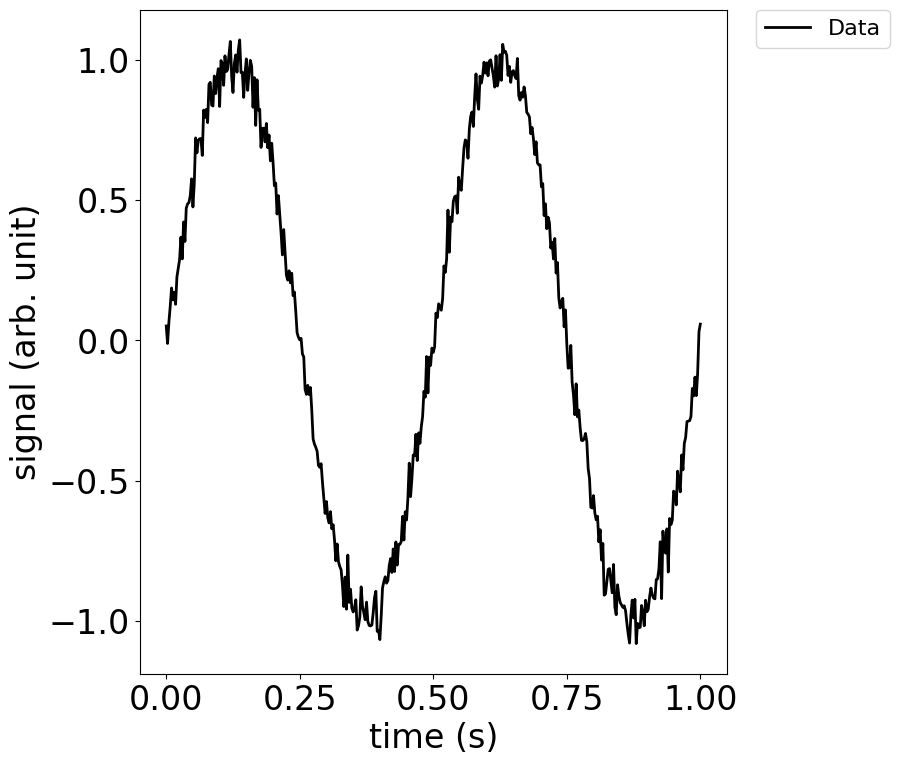

In [6]:
############################################
def g(t,f):
  return 1.0*np.sin( 2.0 * np.pi * f * t )
#
############################################
M       = 401
sigma_y = 0.05
a_true  = 2.0
#
x_data = np.linspace( 0.0, 1.0, num=M, endpoint=True)
y_data = g( x_data, a_true) + np.random.normal(size=M, scale=sigma_y)
#
fig = GrfData( x_data, y_data, x_label='time (s)', y_label='signal (arb. unit)' )
#
#
fig.savefig( FilePath + FileBaseName + '-01.pdf' )

---
事前確率に用いる確率分布
1. 正規分布
$$
{\rm PNormal}(x;\mu,\sigma)=\frac{1}{\sigma\sqrt{2\pi}}
\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right],
\;\;\;
x\in[-\infty,\infty]
$$

2. 一様分布
$$
{\rm PUniform}(x;lower,upper)=
\left\{
  \begin{array}{cc}
    \displaystyle
    \frac{1}{upper - lower},
    &
    x\in[lower,upper]
    \\
    0,
    &
    x\not\in[lower,upper]
  \end{array}
\right.
$$

3. ガンマ分布
$$
{\rm PGamma}(x;\alpha,\beta)=
\frac{\beta^\alpha{}x^{\alpha-1}}{\Gamma(\alpha)}\exp(-\beta{}x),
\;\;\;
x\in[0,\infty]
$$

4. von Mises分布
$$
{\rm PVonMises}(x;\mu,\kappa)
=
\frac{
  \exp
  \left[
    \kappa
    \cos(x-\mu)
  \right]
}{
  2\pi
  I_{0}(\kappa)
}
,
$$

In [7]:
############################################
from math import gamma as gamma_func
############################################
sqrt2pi = np.sqrt( 2 * np.pi )
############################################
# ##1. 正規分布
def PNormal(x, mu, sigma):
  return np.exp( - (x - mu)**2 ) / (sigma * sqrt2pi )
############################################
# ##2. 一様分布
def PUniform(x, lower, upper):
  # res = 1.0 / (upper-lower)
  # res[ (x<lower) ] = 0
  # res[ (x>upper) ] = 0
  #return res
  return (1-np.maximum( np.sign( (x-lower)*(x-upper) ), 0 ))/(upper-lower)
############################################
# ##3. ガンマ分布
def PGamma(x, alpha, beta):
    res = beta**alpha * x**(alpha-1) * np.exp(-beta*x)/ gamma_func(alpha)
    res[(x<0)] = 0
    return res
############################################
# フォン・ミーゼス(von Mises)分布
from scipy.special import iv
#
pi2 = 2 * np.pi
#
def PVonMises(x, mu, kappa):
  I0kappa2pi = pi2 * iv( 0, kappa )
  return np.exp( kappa * np.cos(x - mu) ) / I0kappa2pi

PyMC を用いたサンプリング
* $f$の事前確率: $P(f)=\mathcal{U}(1.8,2.2)$
* RMSDの事前確率: $P(\textrm{RMSD})=\mathcal{U}(0.0,0.2)$

In [8]:
# ############################################
# with pm.Model() as  model:
#   #
#   f    = pm.Uniform( 'f',   lower=1.8,  upper=2.2 )
#   #
#   rmsd = pm.Uniform( 'rmsd',lower=0.0, upper=0.2 )
#   #
#   y    = pm.Normal(  'y', mu=g(x_data,f), sigma=rmsd, observed=y_data)
#   #
#   traceNUTS = pm.sample( 10000, tune=1000, chains=1 )
#   #
# ############################################
# pm.plot_trace(traceNUTS)
# #
# ############################################
# pm.summary(traceNUTS)

In [9]:
# ######################################
# f_mean = float( np.mean(traceNUTS.posterior['f']) )
# f_sd   = float( np.std( traceNUTS.posterior['f']) )
# print('f_mean   = %.6f' % f_mean )
# print('f_sd     = %.6f' % f_sd )
# print('f        =',  Format_MostProbableValue( f_mean, f_sd, 'Hz' ) )
# #
# rmsd_mean = float( np.mean(traceNUTS.posterior['rmsd']) )
# rmsd_sd   = float( np.std( traceNUTS.posterior['rmsd']) )
# print('rmsd_mean   = %.6f' % rmsd_mean )
# print('rmsd_sd     = %.6f' % rmsd_sd )
# print('rmsd        =',  Format_MostProbableValue( rmsd_mean, rmsd_sd, '' ) )
# ######################################
# # f_mean   = 2.000297
# # f_sd     = 0.001011
# # f        = +2.0003 +/- 0.0010 Hz
# # rmsd_mean   = 0.053474
# # rmsd_sd     = 0.001896
# # rmsd        = (+53.5 +/- 1.9)x10^(-3)

誤差関数 
$$
E(f)=\frac{1}{2M}\sum_{i=1}^{M}[y_{i}-g(t_{i};f)]^{2} 
$$

In [10]:
############################################
def E(f):
  return np.sum( (y_data - g(x_data,f))**2 ) / (2*M)

誤差関数のデータ
* $f=0\sim6.0$ Hz

In [11]:
############################################
f_low  = 0.5
f_high = 6.0
f_step = 0.01
f_num  = int( np.round( (f_high - f_low)/f_step + 1 ) )
#
f_data = np.linspace( f_low, f_high, num=f_num, endpoint=True)
E_data = np.zeros_like( f_data )

############################################
idx_ = 0
for f in f_data:
  E_data[idx_] = E(f)
  idx_         = idx_ + 1

RXMC法の参考文献
* Simultaneous Estimation of Noise Variance and Number of Peaks in Bayesian Spectral Deconvolution
  * S. Tokuda, K. Nagata, M. Okada
  * https://doi.org/10.7566/JPSJ.86.024001

In [12]:
############################################
# レプリカ数
L = 5 # 10
#
# 各レプリカの逆温度の上限: $b_{L}$
b_max = 1 / sigma_y**2
#
# 各レプリカの逆温度の下限: $b_{2}$
sigma_min_max_ratio = 5
#
# 各レプリカの逆温度の下限: $b_{2}$
b_min = 1 / (sigma_y * sigma_min_max_ratio)**2
#
b_tab = np.logspace( np.log10(b_min), np.log10(b_max), num=L-1)
#
# 各レプリカの逆温度の下限: $b_{1}=0$
b_tab = np.insert( b_tab, 0, 0.0 )
#
############################################
b_tab_c = len( b_tab )
#
b_idx = 0
print( "l = %3d: b_%d = %.3E" % (b_idx, b_idx, b_tab[b_idx]) )
#
for b_idx in range(1,b_tab_c):
  print( "l = %3d: b_%d = %.3E, b_%d/b_%d = %.3f" %
          (b_idx, b_idx, b_tab[b_idx], b_idx-1, b_idx,(b_tab[b_idx-1]/b_tab[b_idx])) )

l =   0: b_0 = 0.000E+00
l =   1: b_1 = 1.600E+01, b_0/b_1 = 0.000
l =   2: b_2 = 4.678E+01, b_1/b_2 = 0.342
l =   3: b_3 = 1.368E+02, b_2/b_3 = 0.342
l =   4: b_4 = 4.000E+02, b_3/b_4 = 0.342


各レプリカの誤差関数 $ M\,b_{\ell}\,E(f)$

In [13]:
############################################
MbEs = np.zeros( (b_tab_c, len(E_data) ) )
#
# グラフのy軸の範囲
y_heights = 0.0
#
for b_idx in range(b_tab_c):
  b_l = b_tab[ b_idx ]
  MbEs[b_idx] = M * b_l * E_data
  #
  MbE_min = np.amin(MbEs[b_idx])
  MbE_max = np.amax(MbEs[b_idx])
  #
  y_heights = y_heights + MbE_max - MbE_min
  #
  print( "l = %3d : min(MbE) = %10.3f, max(MbE) = %10.3f" % (b_idx, MbE_min, MbE_max ) )
#
print( y_heights )

l =   0 : min(MbE) =      0.000, max(MbE) =      0.000
l =   1 : min(MbE) =      7.458, max(MbE) =   4110.861
l =   2 : min(MbE) =     21.806, max(MbE) =  12020.229
l =   3 : min(MbE) =     63.761, max(MbE) =  35147.363
l =   4 : min(MbE) =    186.439, max(MbE) = 102771.513
153770.501576197


全てのレプリカの$ M\,b_{\ell}\,E(f)$をy軸オフセットを調整して描く関数

In [14]:
############################################
def Grf_RXMC_MbEs( x_data_, x_label_, M_, b_tab_, E_data_, iter=None ):
  #
  # print( len( x_data_ ) )
  #
  offset_ratio = 20
  #
  plt.rcParams['font.size'] = 15
  #
  fig = plt.figure( figsize=(6.5,5) )
  #
  fig.subplots_adjust(left=0.12, right=0.77, top=0.95, bottom=0.12)
  #
  ax1 = fig.add_subplot(1,1,1)
  ax1.set_xlabel( x_label_ )
  ax1.set_ylabel( r'$M\,b_{\ell}\,E$' )
  ax1.ticklabel_format( axis='y', style='sci', scilimits=(0, 0) ) # scilimits=(0, 0) 全範囲
  #
  # 逆温度の個数
  b_tab_c = len( b_tab_ )
  #
  # 描く各レプリカの誤差関数 M b Eを用意する
  MbEs = np.zeros( (b_tab_c, len(E_data_) ) )
  #
  # 各 M b Eグラフのyoffset
  y_offsets = np.zeros( b_tab_c )
  #
  # 逆温度最大のレプリカでオフセットを決める
  b_idx =  b_tab_c - 1
  b_l = b_tab_[ b_idx ]
  MbEs[b_idx] = M_ * b_l * E_data_
  #
  MbE_min = np.amin(MbEs[b_idx])
  MbE_max = np.amax(MbEs[b_idx])
  MbE_dif = MbE_max - MbE_min
  #
  # 低温極限の次だけ逆に食い込ませる
  y_offset = y_offsets[ b_idx ] + MbE_max - 2 * MbE_dif / offset_ratio
  y_offsets[ b_idx - 1 ] = y_offset
  #
  for b_idx in reversed( range(b_tab_c-1) ):
    #
    b_l = b_tab_[ b_idx ]
    MbEs[b_idx] = M_ * b_l * E_data_
    #
    MbE_min = np.amin(MbEs[b_idx])
    MbE_max = np.amax(MbEs[b_idx])
    #
    if b_idx > 0:
      y_offset = y_offsets[ b_idx ] + MbE_max + MbE_dif / offset_ratio
      y_offsets[ b_idx - 1 ] = y_offset
    #
    # print( "l = %3d : min(MbE) = %10.3f, max(MbE) = %10.3f, dif(MbE) = %10.3f, offset = %10.3f"
    #       % (b_idx, MbE_min, MbE_max, MbE_dif, y_offsets[ b_idx ] ) )
    #
  #
  # カラーマップを b_tab の要素数で分割
  cm = plt.get_cmap( 'rainbow', b_tab_c )
  #
  for b_idx in range(b_tab_c):
    #
    b_l = b_tab_[ b_idx ]
    #
    # print( "l = %3d : b_l = %10.3f, offset = %10.3f"
    #       % (b_idx, b_l, y_offsets[ b_idx ] ) )
    #
    y_label  = r'$M\times{}b_{%d}\times{}E(f)$' % (b_idx+1)
    #
    ax1.plot( x_data_, MbEs[b_idx] + y_offsets[ b_idx ],
              color=cm( b_tab_c - b_idx - 1),
              label=y_label, linewidth=2.0, linestyle='solid' )
    #
    #
    ax1.axhline( y=y_offsets[ b_idx ], linewidth=1.0, color=cm( b_tab_c - b_idx - 1), linestyle='dashed' )
  #
  if iter is not None:
    left, right = ax1.set_xlim()
    bot, top    = ax1.set_ylim()
    ax1.text( right, bot, "iter = %5d" % iter, fontsize=16,
              horizontalalignment="right", verticalalignment="bottom" )
  #
  plt.legend( fontsize=8,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0 )
  #
  return y_offsets, plt, fig, ax1, cm

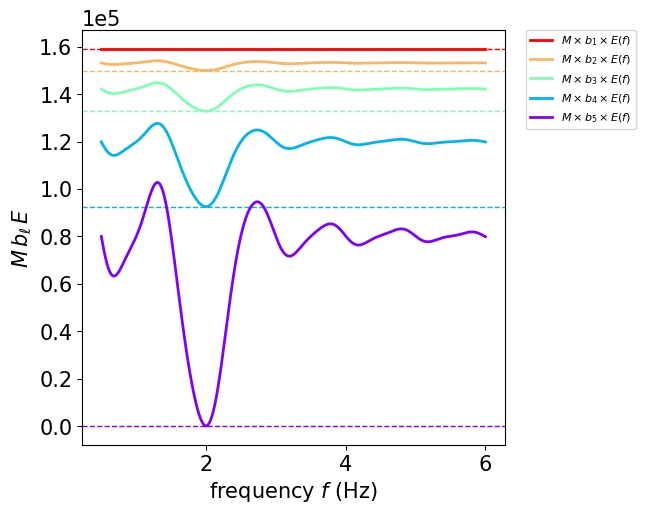

In [15]:
############################################
y_offsets, plt, fig, ax1, cm = Grf_RXMC_MbEs( f_data, r'frequency $f$ (Hz)', M, b_tab, E_data )
plt.show()
#
fig.savefig( FilePath + FileBaseName + '-MbEs-01.pdf' )

* $f$の事前確率
  $$
  P(f)=\mathcal{U}(f_\textrm{low},f_\textrm{high})
  $$

In [16]:
############################################
def Prior_f( f ):
  if (f_high - f)*(f - f_low) >= 0:
    return 1/(f_high - f_low)
  else:
    return 0.0

* $f$の事後確率
  $$
  P(f|\boldsymbol{D},b)
  \propto
  \exp
  \left[
      -M\,b\,E(f)
  \right]
  \,
  P(f)
  $$

* 採択率$r(f_1\rightarrow{}f_2)$

  $$
  r
  =
  \textrm{min}
  \left[
    1,
    \frac{
      P(f_2|\boldsymbol{D},b)
    }{
      P(f_1|\boldsymbol{D},b)
    }
  \right]
  $$

  $$
  \frac{
    P(f_2|\boldsymbol{D},b)
  }{
    P(f_1|\boldsymbol{D},b)
  }
  =
  \frac{
    \exp
    \left[
        -M\,b\,E(f_2)
    \right]
    \,
    P(f_2)
  }{
    \exp
    \left[
        -M\,b\,E(f_1)
    \right]
    \,
    P(f_1)
  }
  =
  \exp
  \left\{
      -M\,b
      \left[
        E(f_2)
        -
        E(f_1)
      \right]
  \right\}
  \frac{
    P(f_2)
  }{
    P(f_1)
  }
  $$

In [17]:
############################################
def Metropolis( f_t, b, f_step ):
  #
  # 候補値の生成
  f_dash = f_t + np.random.uniform( -f_step, +f_step, 1)
  #
  # 候補値の事前確率がない場合は、無条件で棄却
  if Prior_f( f_dash ) == 0:
    return f_t
  #
  # 事後確率比
  r0 = np.exp( - M * b * ( E(f_dash) - E(f_t) ) ) * Prior_f( f_dash ) / Prior_f( f_t )
  #
  if r0 >= 1.0:
    return f_dash
  #
  # U(0,1)との比較
  if np.random.uniform( 0, 1.0, 1) < r0:
    return f_dash
  else:
    return f_t

* 交換率

$$
u(b_{\ell}\leftrightarrow{}b_{\ell+1})
=
    \textrm{min}
    \left[
        1,    
        \frac{
            P(\boldsymbol{\theta}_{\ell+1}|\boldsymbol{D},b_{\ell})
            P(\boldsymbol{\theta}_{\ell}|\boldsymbol{D},b_{\ell+1})
        }{
            P(\boldsymbol{\theta}_{\ell}|\boldsymbol{D},b_{\ell})
            P(\boldsymbol{\theta}_{\ell+1}|\boldsymbol{D},b_{\ell+1})
        }
    \right]
$$

$$
\frac{
  P(\boldsymbol{\theta}_{\ell+1}|\boldsymbol{D},b_{\ell})
  P(\boldsymbol{\theta}_{\ell}|\boldsymbol{D},b_{\ell+1})
}{
  P(\boldsymbol{\theta}_{\ell}|\boldsymbol{D},b_{\ell})
  P(\boldsymbol{\theta}_{\ell+1}|\boldsymbol{D},b_{\ell+1})
}
=
\frac{
  \exp
  \left[
      -M\,b_{\ell}\,E(f_{\ell+1})
  \right]
  \,
  \exp
  \left[
      -M\,b_{\ell+1}\,E(f_{\ell})
  \right]
}{
  \exp
  \left[
      -M\,b_{\ell}\,E(f_{\ell})
  \right]
  \,
  \exp
  \left[
      -M\,b_{\ell+1}\,E(f_{\ell+1})
  \right]
}
$$

$$
r(b_{\ell}\leftrightarrow{}b_{\ell+1})
=
\exp
\left\{
    -M
    \left(
      b_{\ell}
      -
      b_{\ell+1}
    \right)
    \left[
      E(f_{\ell+1})
      -
      E(f_{\ell})
    \right]
\right\}
$$

In [18]:
############################################
def DoExchange( b_idx_, ax, y_offsets_ ):
  #
  # before
  before_x0 = f_t[ b_idx_     ]
  before_x1 = f_t[ b_idx_ + 1 ]
  before_y0 = M * b_tab[ b_idx_     ] * E( before_x0 ) + y_offsets_[ b_idx_     ]
  before_y1 = M * b_tab[ b_idx_ + 1 ] * E( before_x1 ) + y_offsets_[ b_idx_ + 1 ]
  #
  f_t[ b_idx_ + 1 ], f_t[ b_idx_ ] = f_t[ b_idx_ ], f_t[ b_idx_ + 1 ]
  #
  # after
  after_x0 = f_t[ b_idx_ + 1   ]
  after_x1 = f_t[ b_idx_ ]
  after_y0 = M * b_tab[ b_idx_ + 1 ] * E( after_x0 ) + y_offsets_[ b_idx_ + 1 ]
  after_y1 = M * b_tab[ b_idx_     ] * E( after_x1 ) + y_offsets_[ b_idx_     ]
  #
  ax1.annotate('', xy=(after_x0, after_y0), xytext=(before_x0,before_y0),
                arrowprops=dict(shrink=0, width=0.5, headwidth=3,
                                headlength=5, connectionstyle='arc3',
                                facecolor='gray', edgecolor='gray') )
  #
  ax1.annotate('', xy=(after_x1, after_y1), xytext=(before_x1,before_y1),
                arrowprops=dict(shrink=0, width=0.5, headwidth=3,
                                headlength=5, connectionstyle='arc3',
                                facecolor='gray', edgecolor='gray') )

############################################
def Exchange( b_idx_, ax, y_offsets_ ):
  #
  b_dif = b_tab[ b_idx_ ] - b_tab[ b_idx_+ 1 ]
  E_dif = E( f_t[ b_idx_ + 1 ] ) - E( f_t[ b_idx_ ] )
  #
  r0 = np.exp( - M * b_dif * E_dif )
  #
  if r0 >= 1.0:
    DoExchange( b_idx_, ax, y_offsets_ )
    # f_t[ b_idx_ + 1 ], f_t[ b_idx_ ] = f_t[ b_idx_ ], f_t[ b_idx_ + 1 ]
    return
  #
  # U(0,1)との比較
  if np.random.uniform( 0, 1.0, 1) < r0:
    DoExchange( b_idx_, ax, y_offsets_ )
    # f_t[ b_idx_ + 1 ], f_t[ b_idx_ ] = f_t[ b_idx_ ], f_t[ b_idx_ + 1 ]
    return

アニメーション用のグラフをシリーズで出力する
* RXMCの設定
* 初期値のプロット
* 繰り返しの実行

C:\Users\iakai\AppData\Local\Temp\ipykernel_39260\1214866056.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_t[ b_idx ] = f_t__
C:\Users\iakai\AppData\Local\Temp\ipykernel_39260\2938096608.py:34: RuntimeWarning: overflow encountered in exp
  r0 = np.exp( - M * b_dif * E_dif )


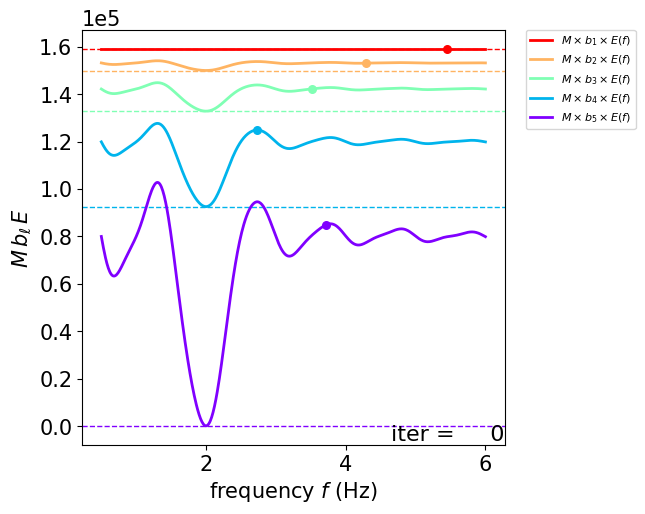

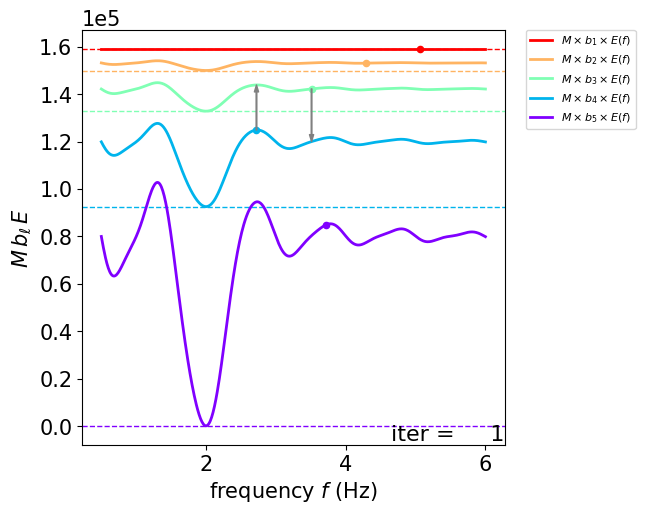

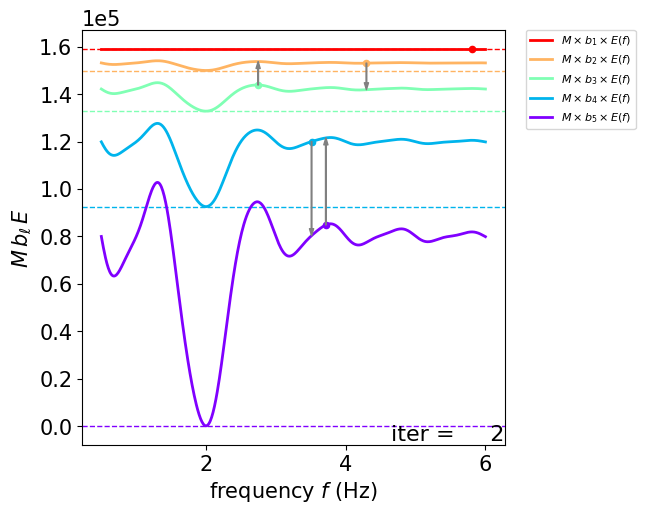

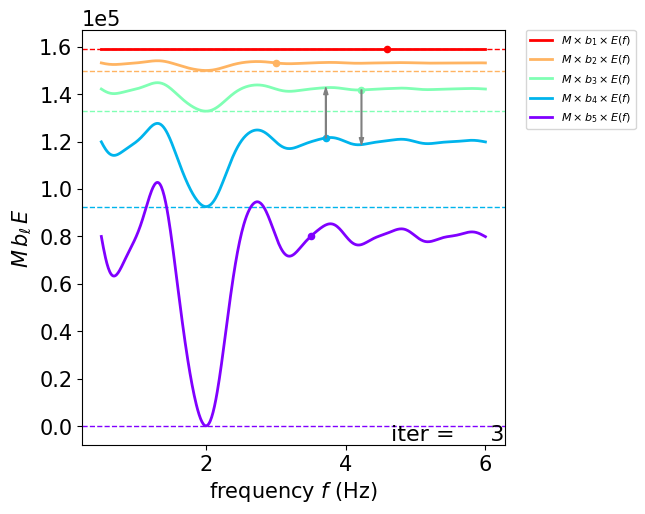

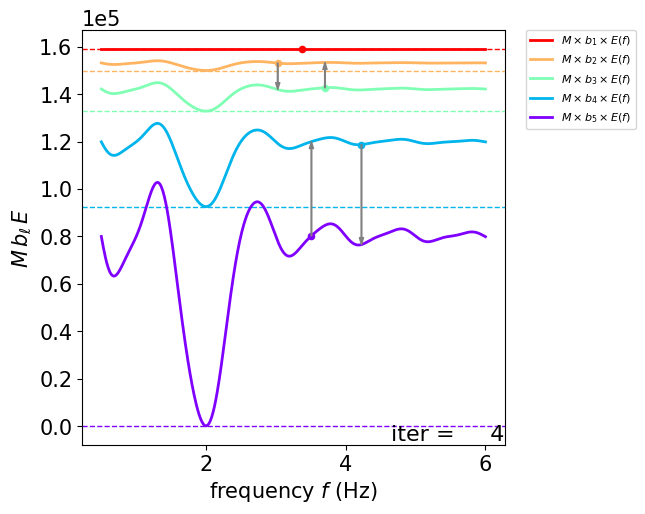

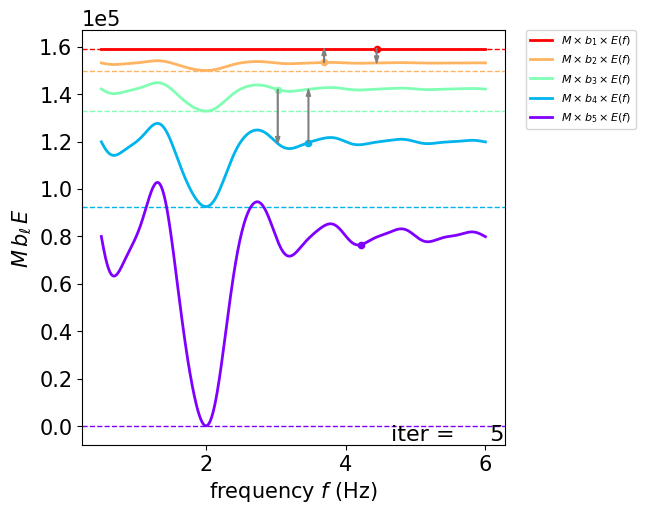

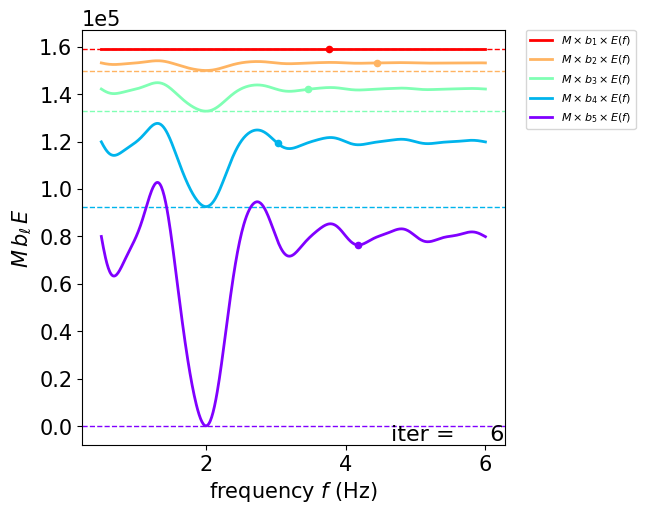

C:\Users\iakai\AppData\Local\Temp\ipykernel_39260\3452112228.py:12: RuntimeWarning: overflow encountered in exp
  r0 = np.exp( - M * b * ( E(f_dash) - E(f_t) ) ) * Prior_f( f_dash ) / Prior_f( f_t )


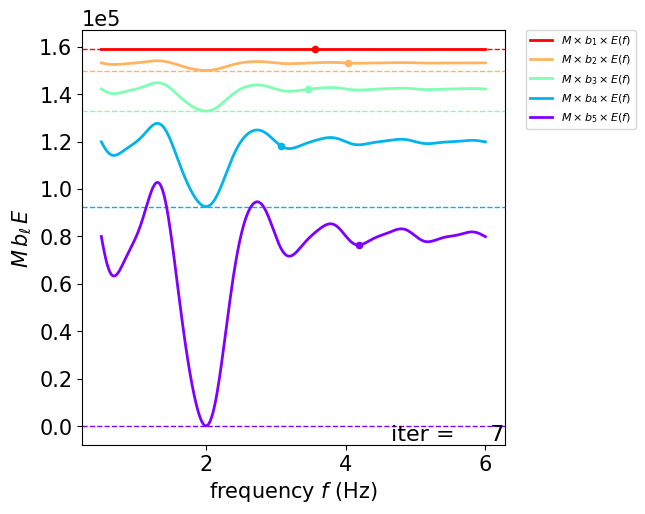

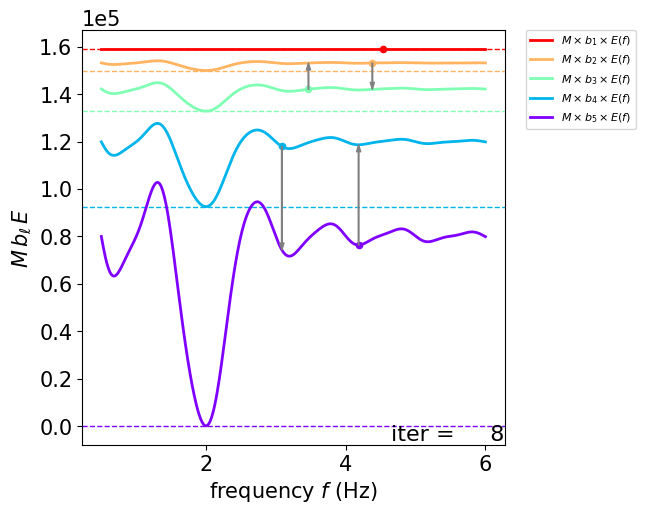

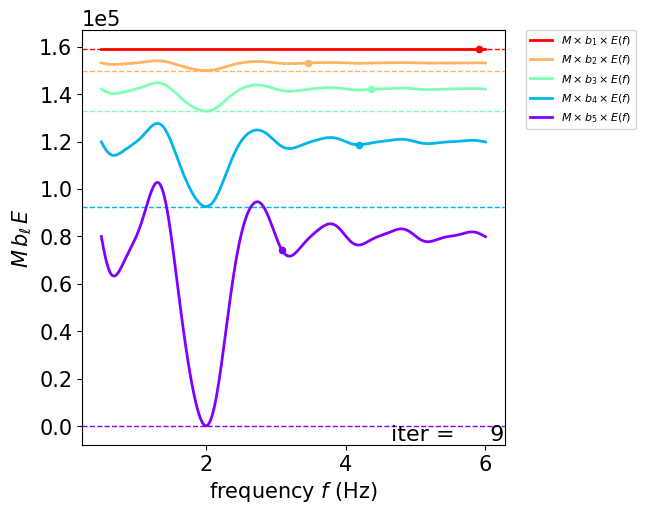

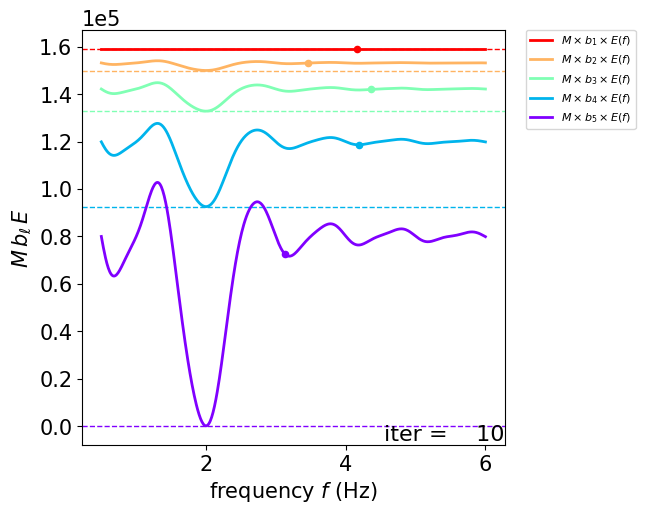

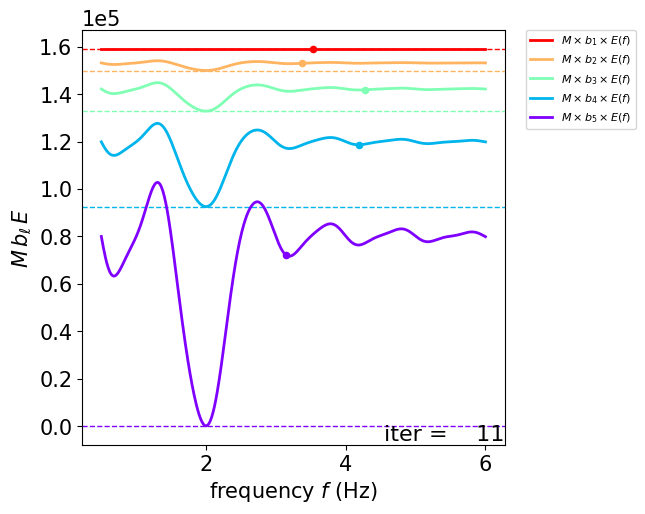

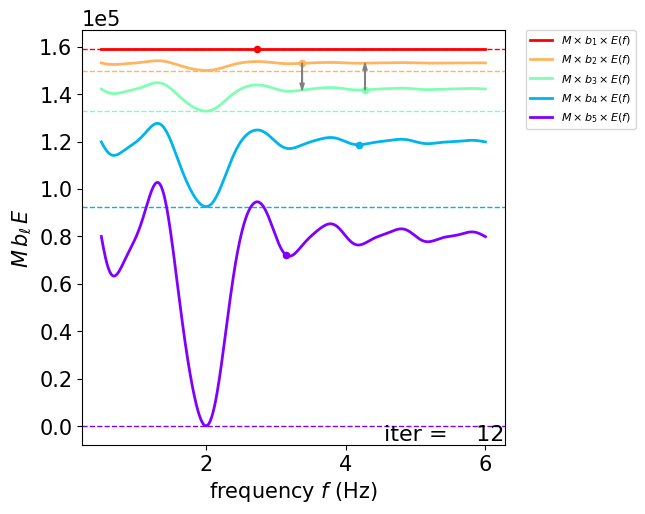

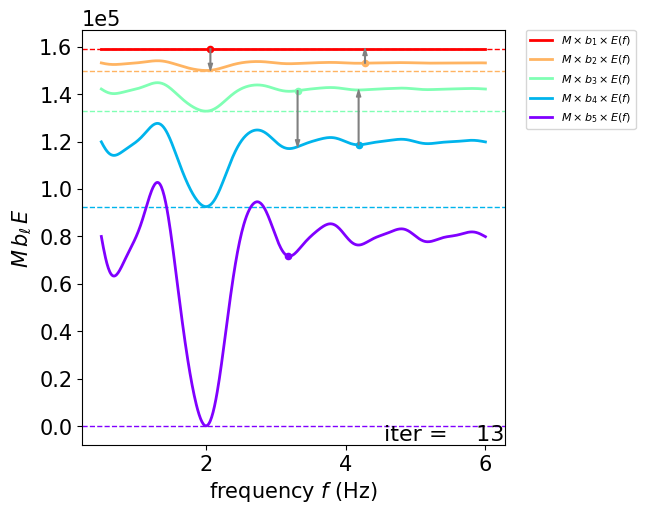

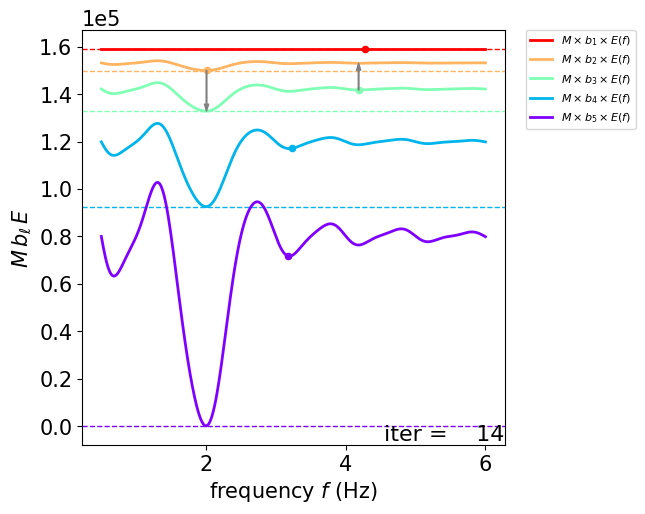

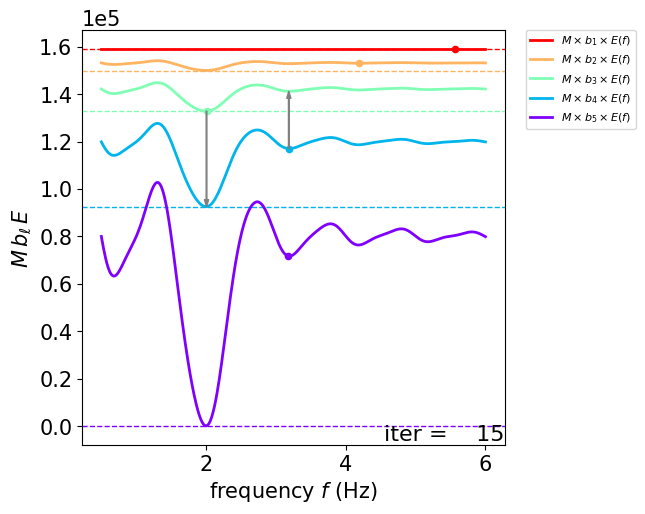

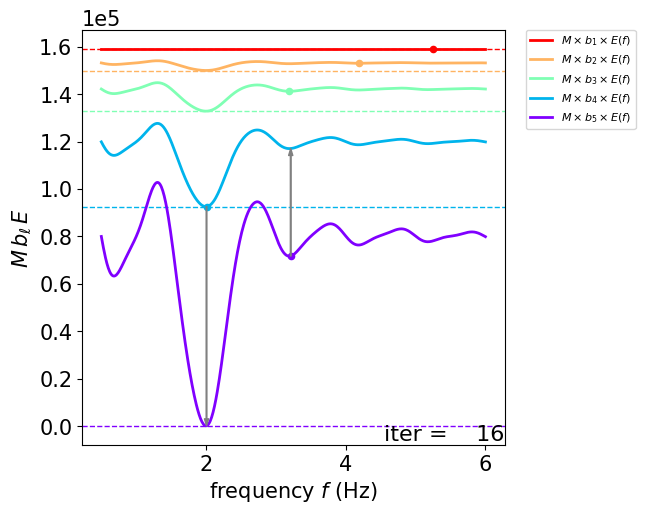

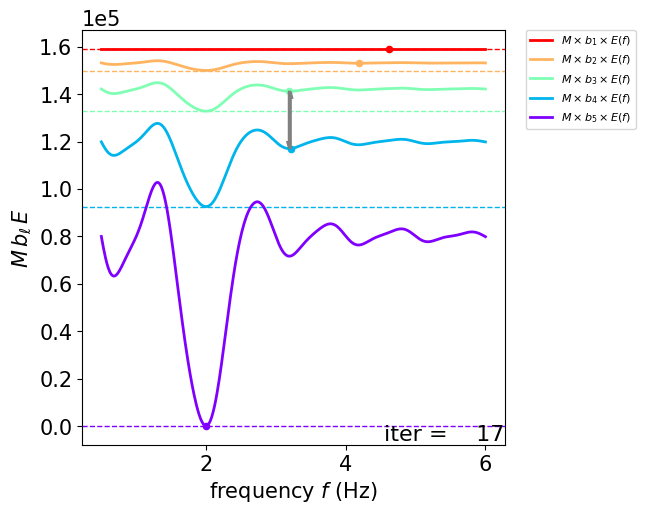

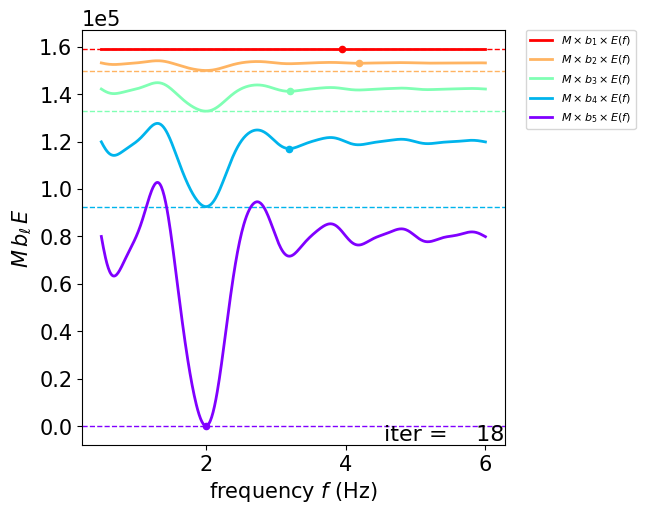

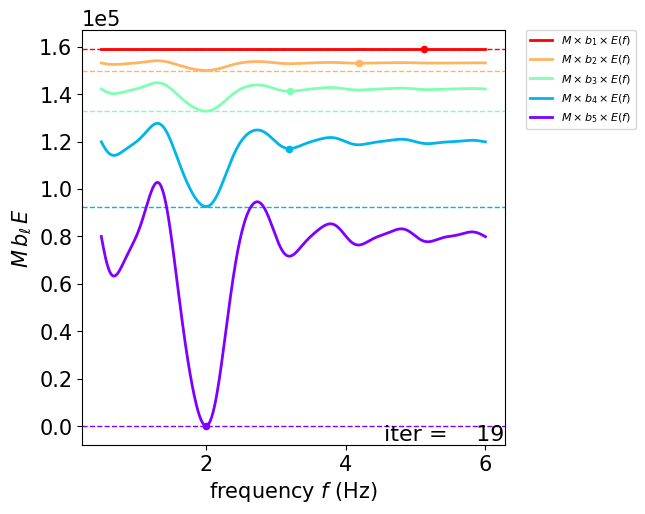

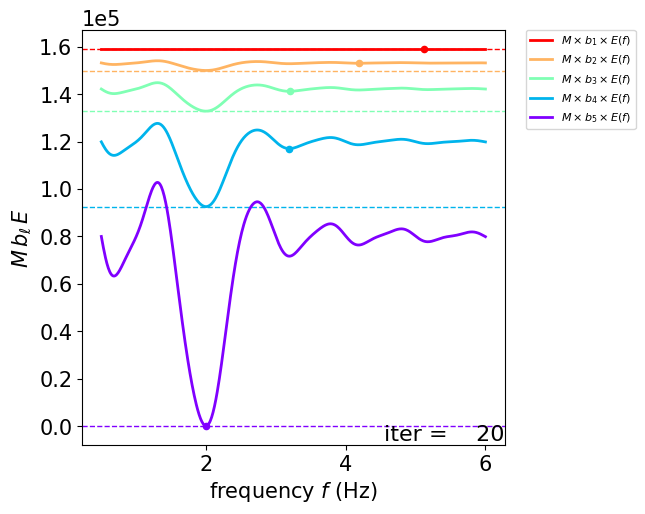

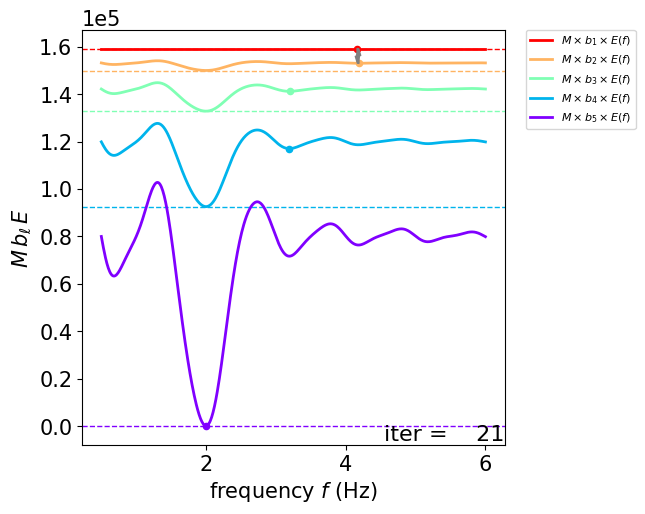

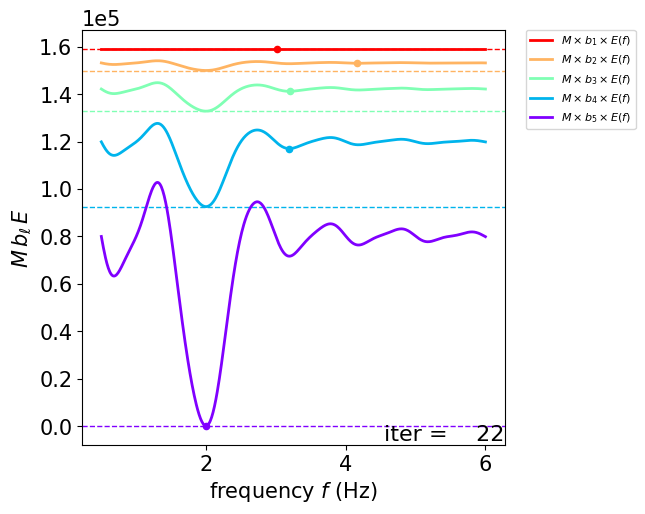

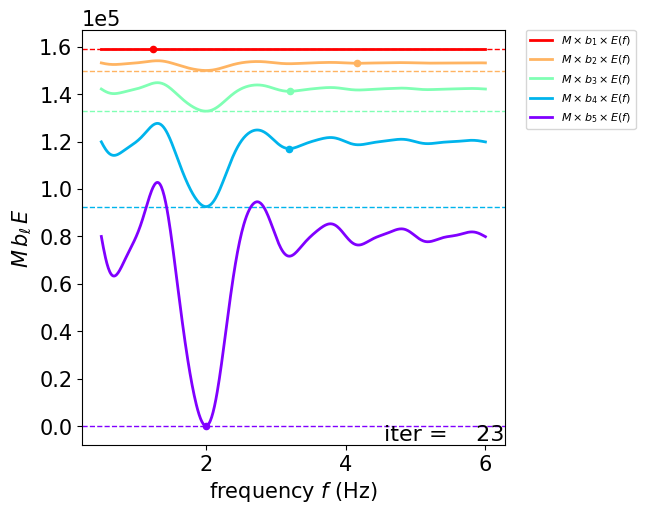

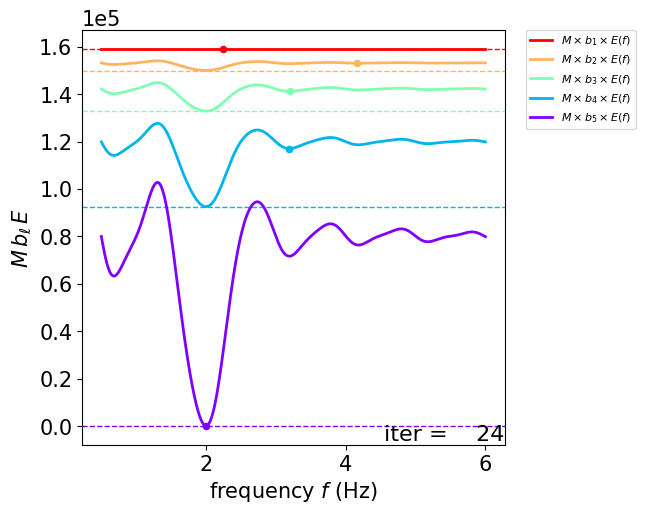

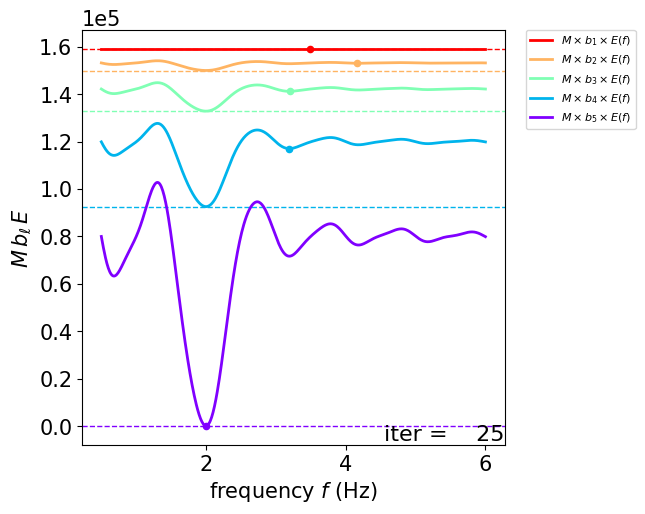

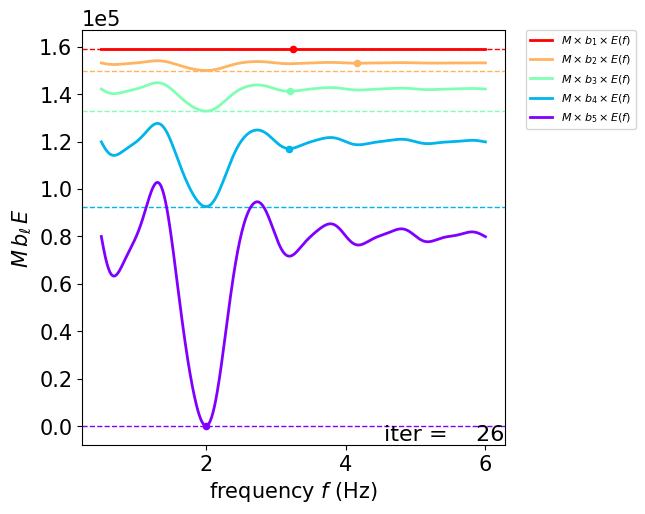

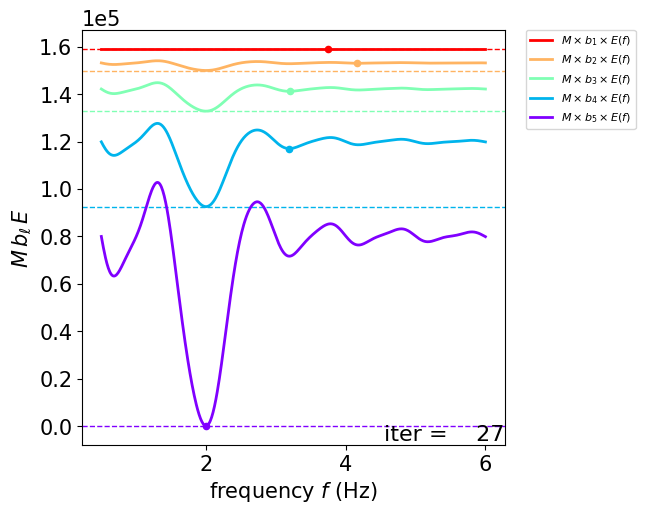

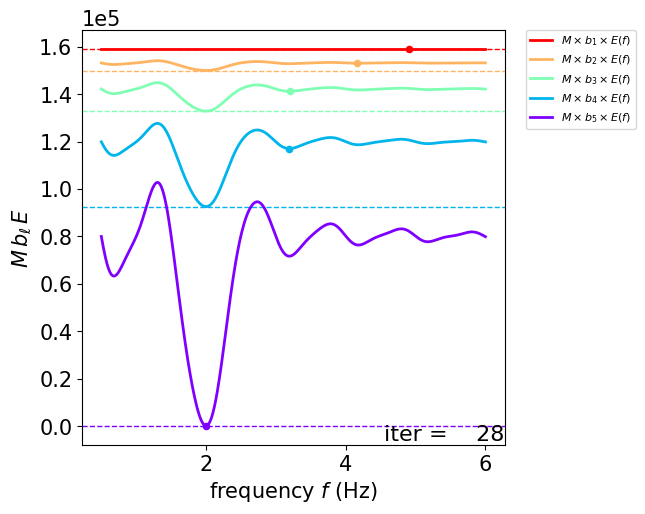

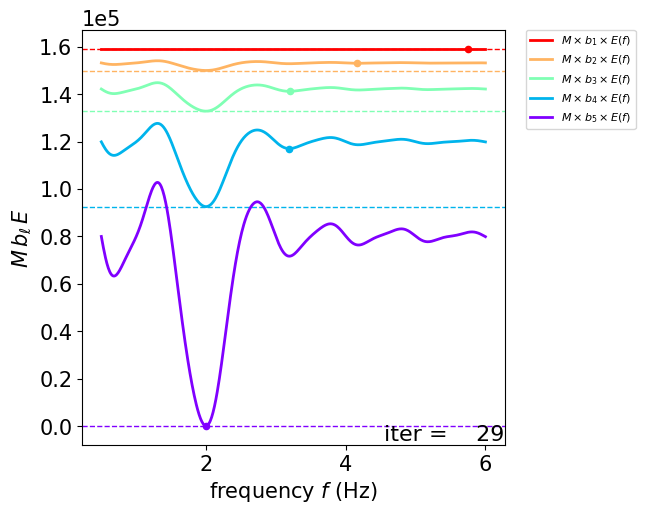

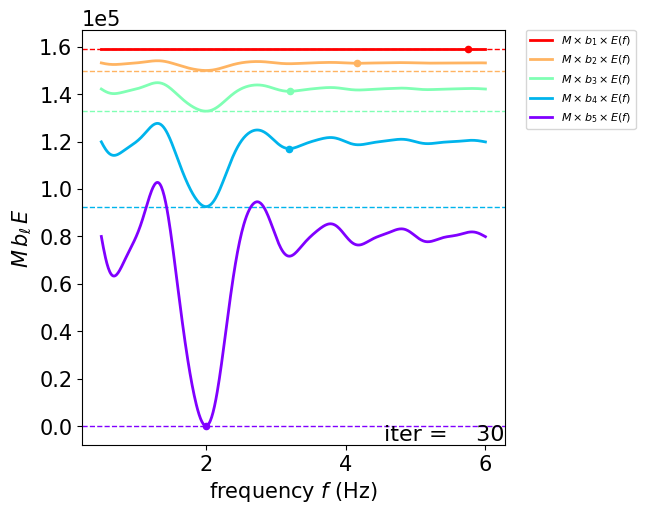

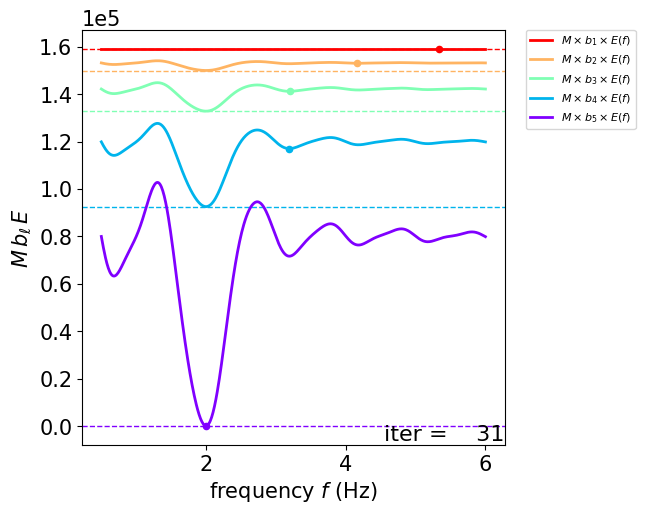

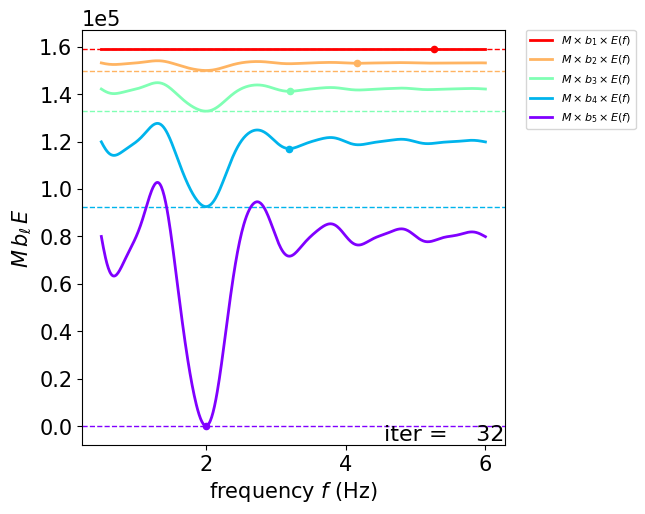

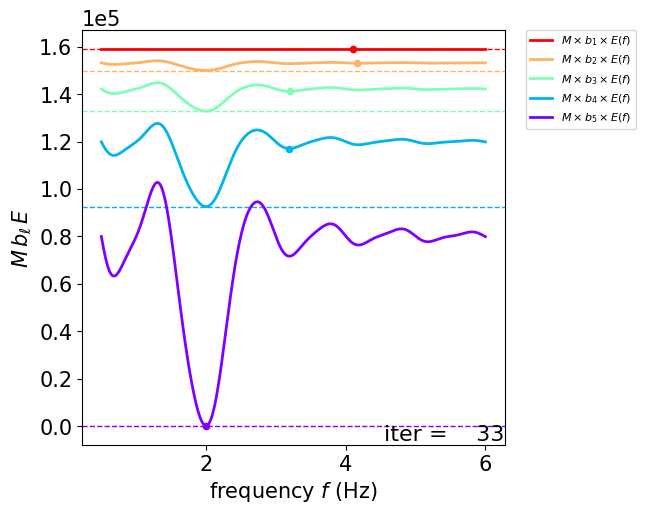

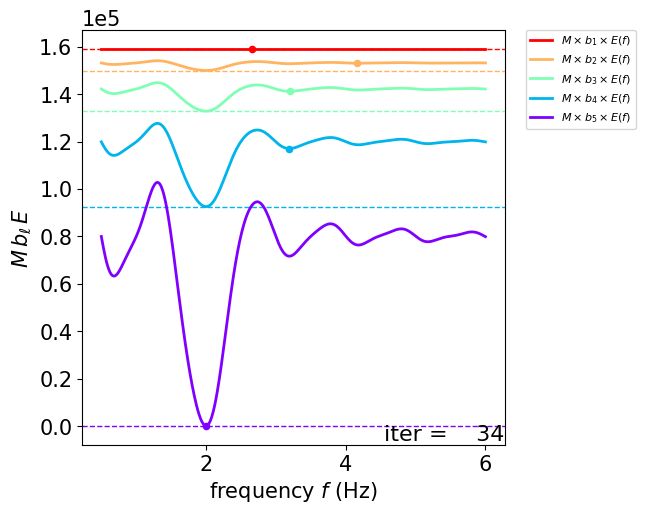

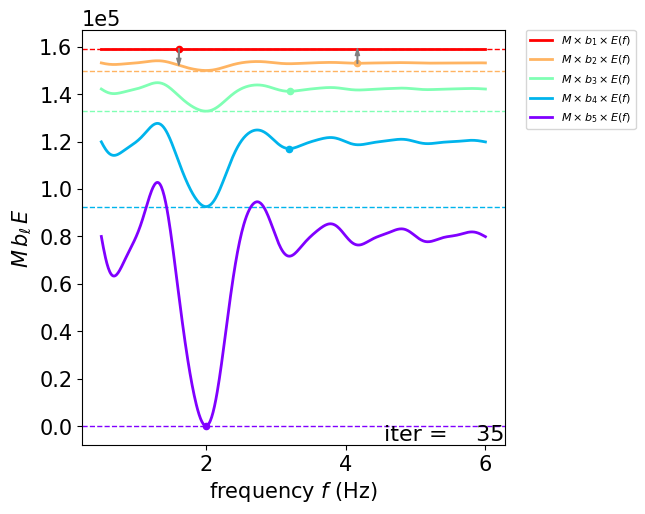

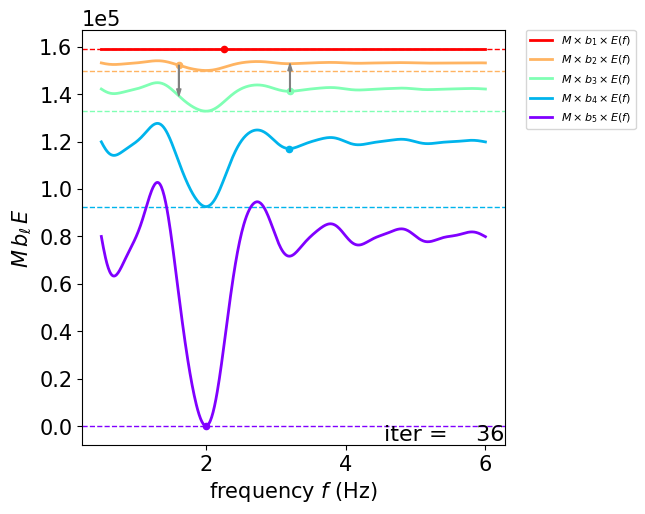

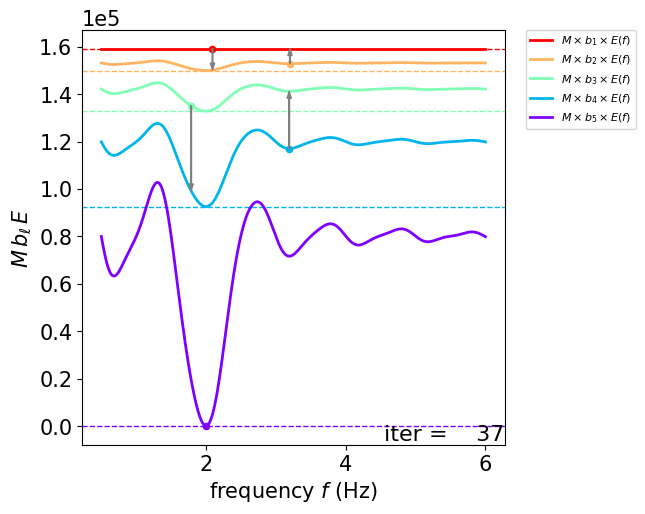

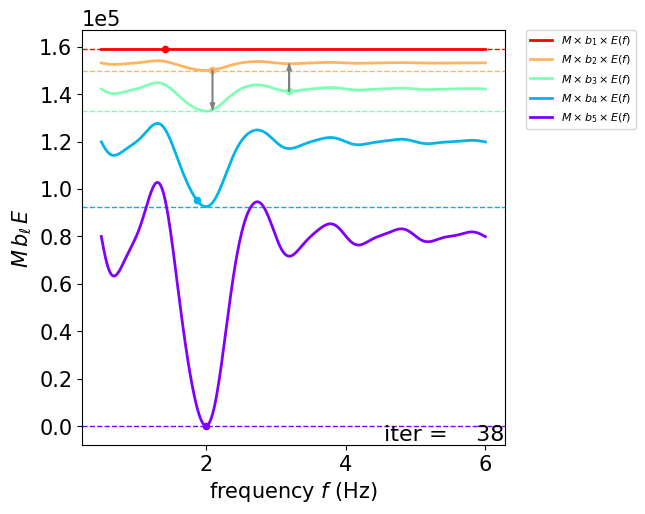

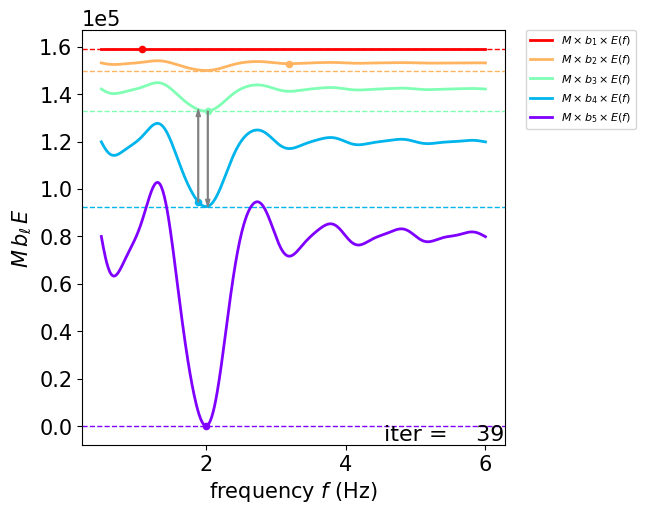

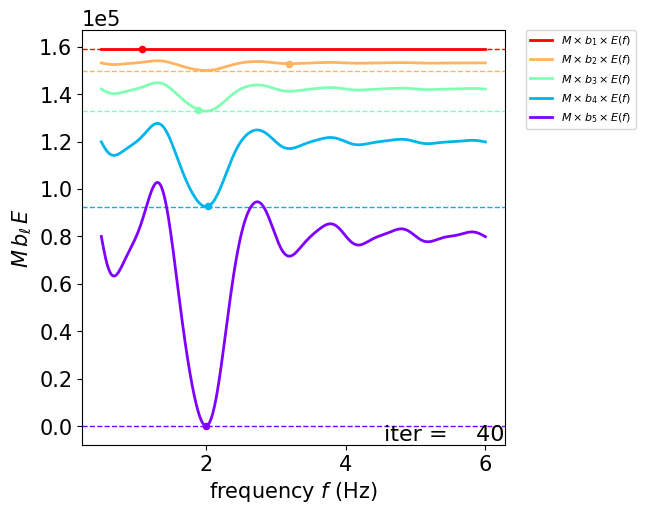

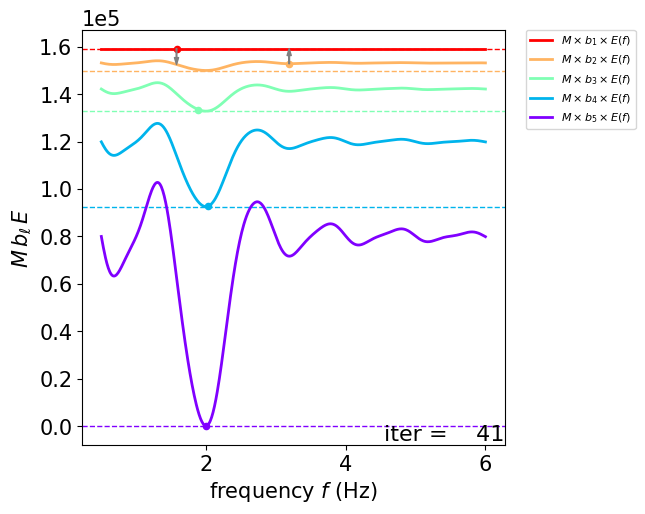

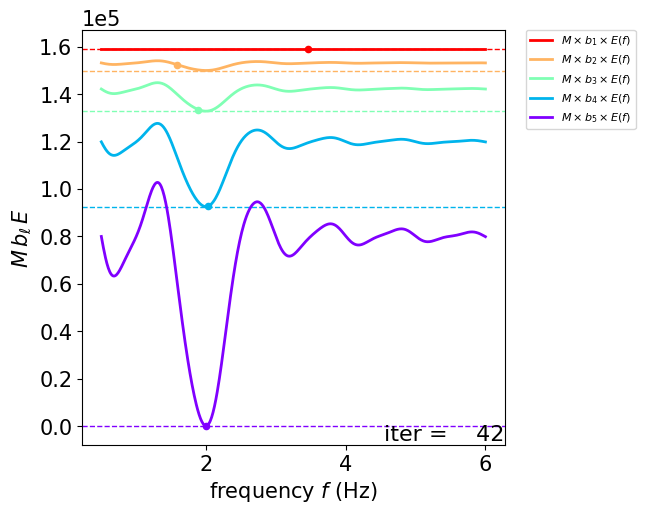

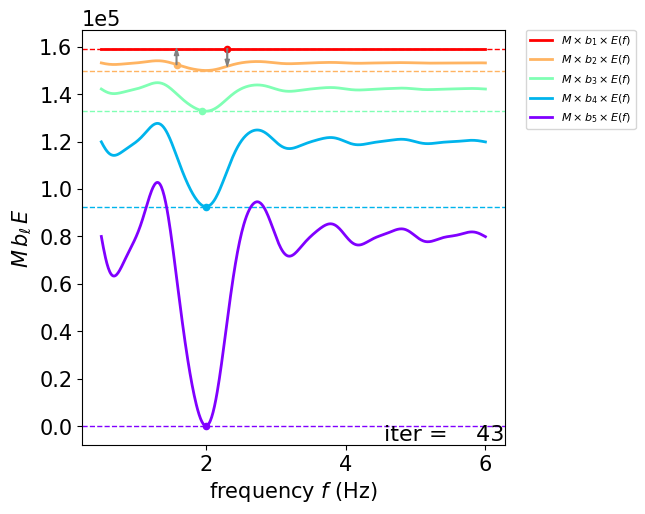

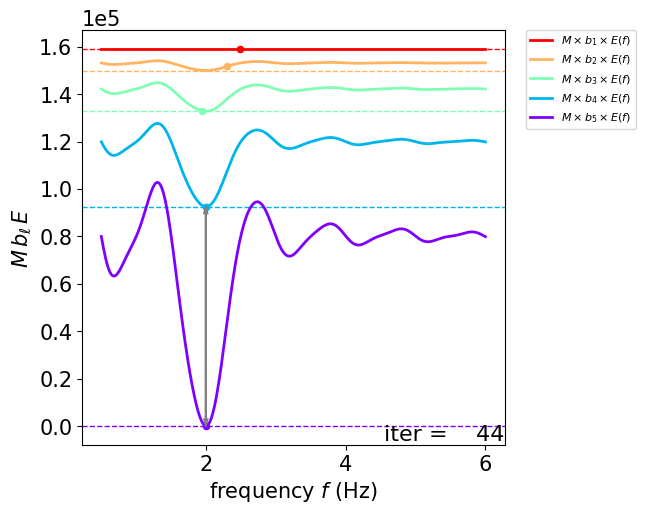

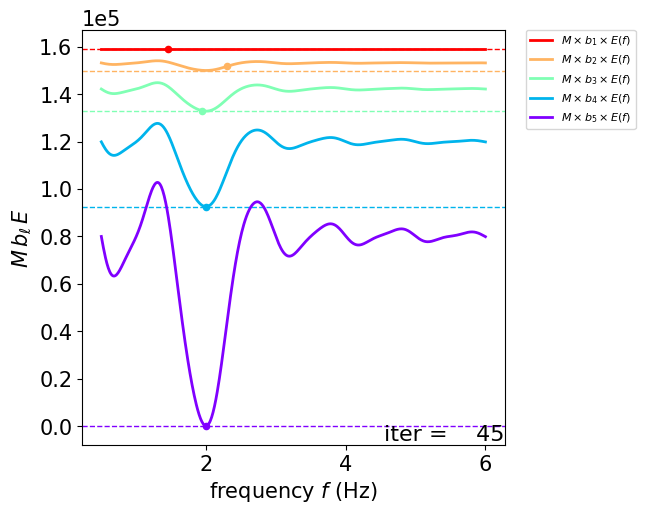

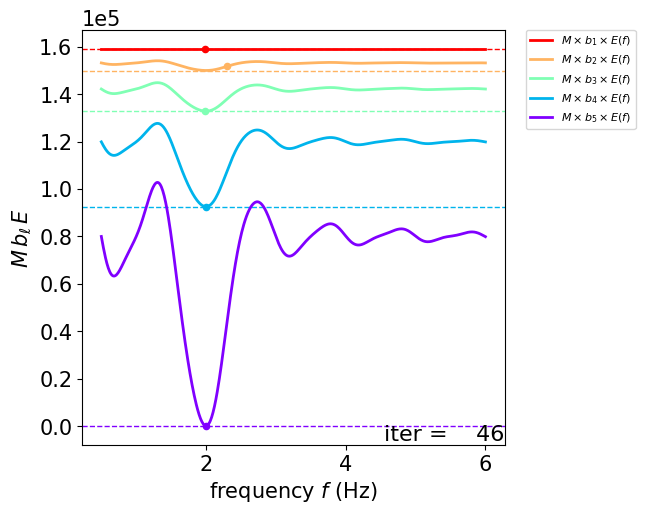

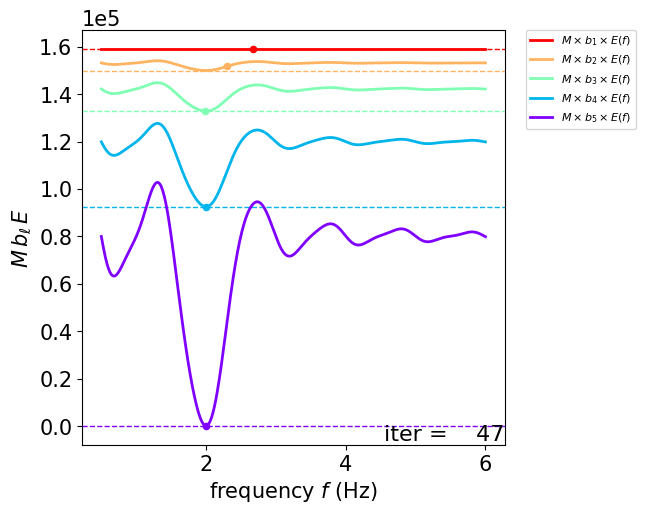

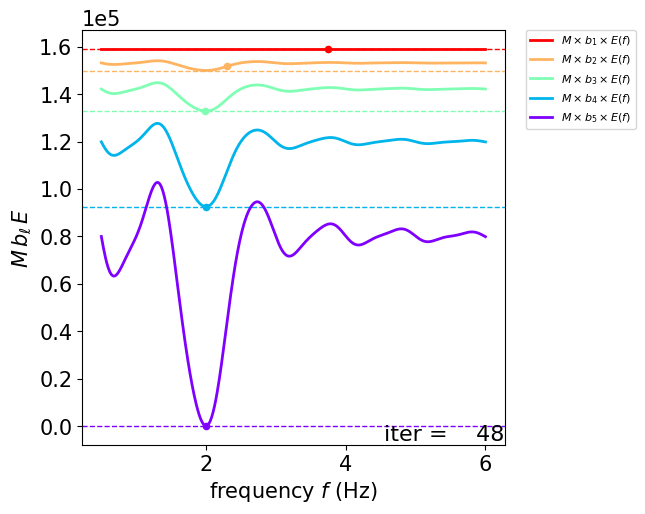

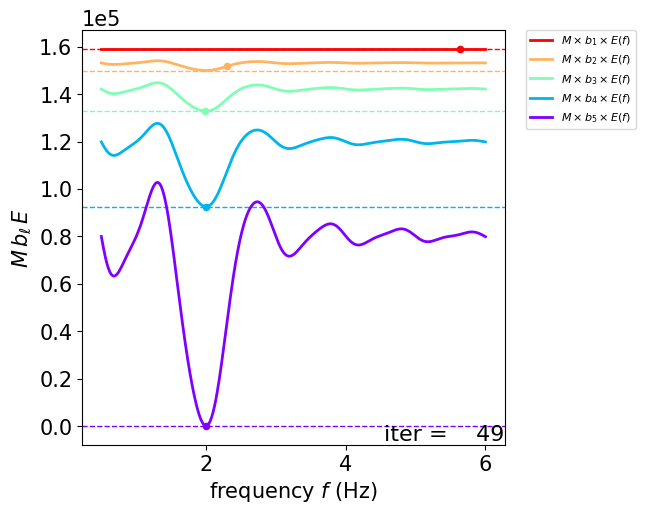

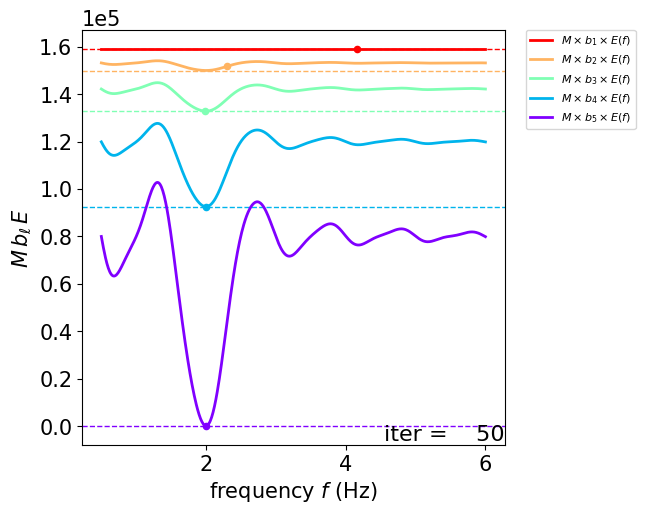

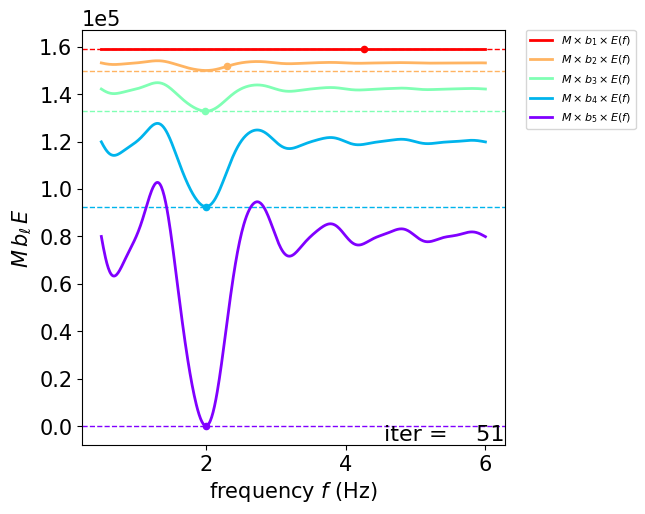

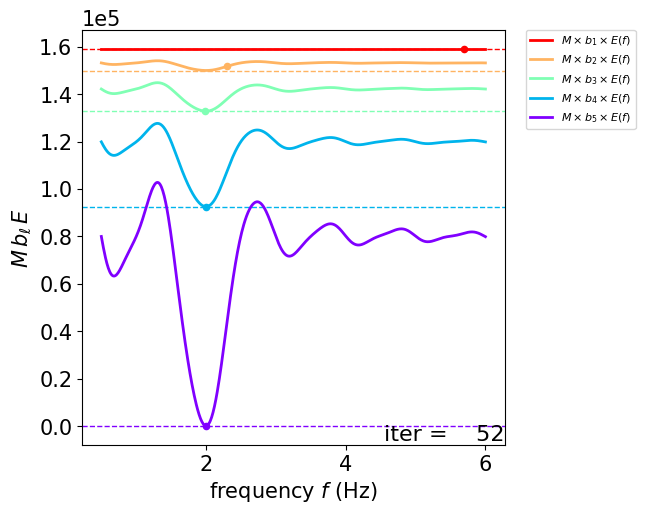

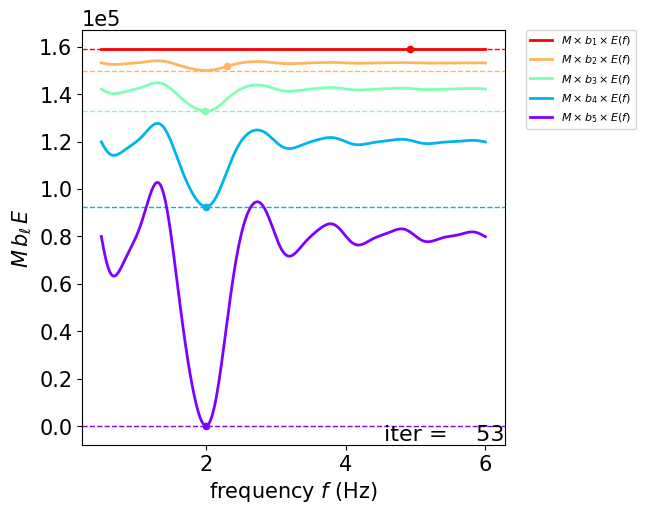

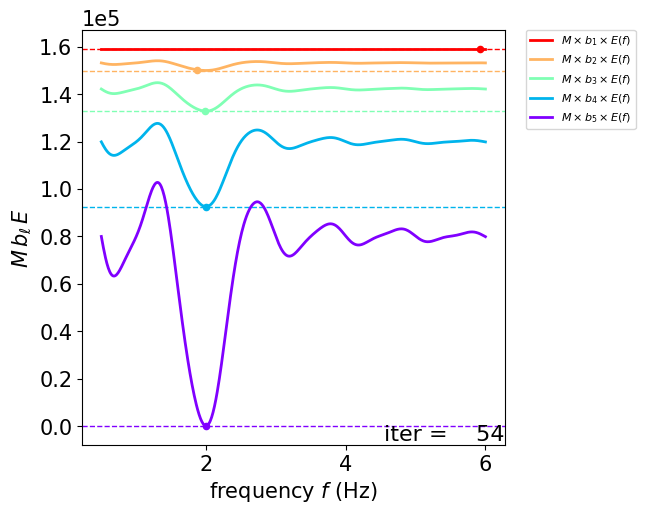

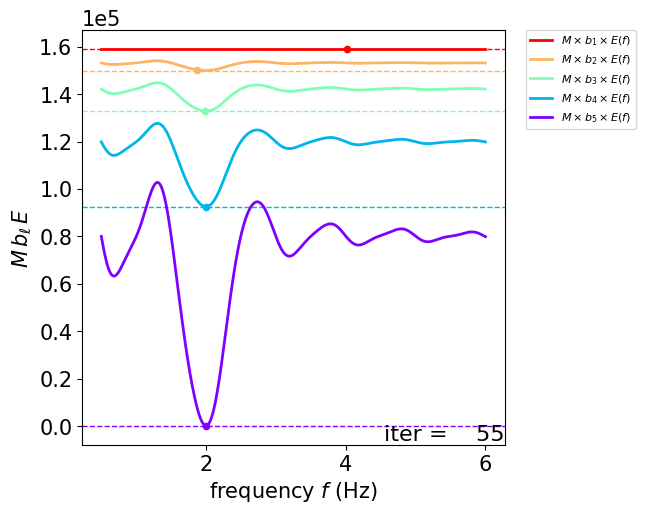

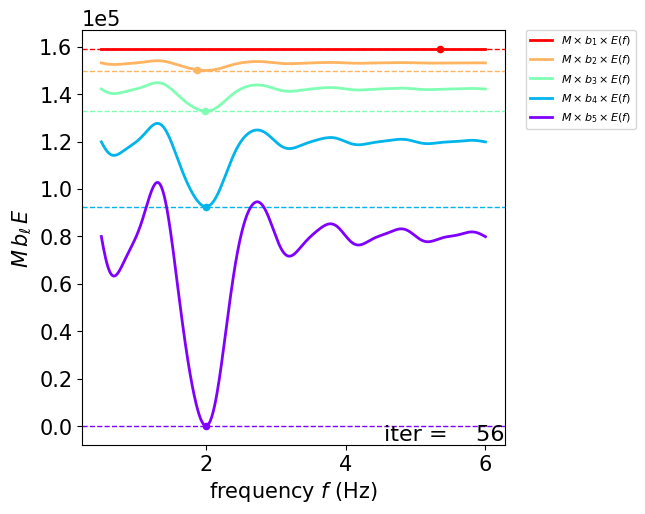

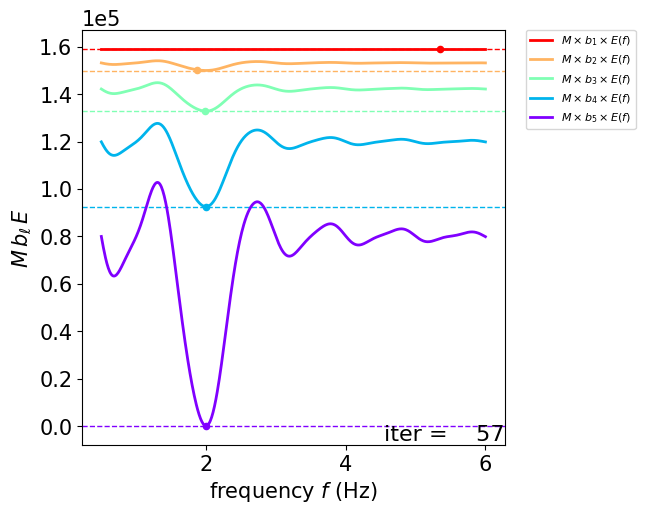

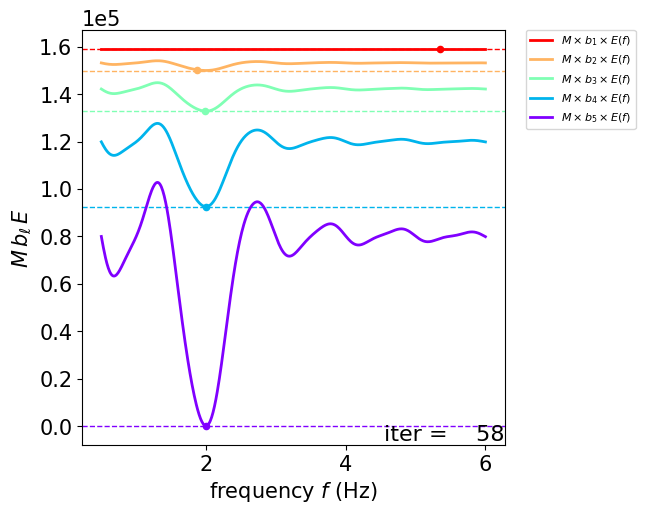

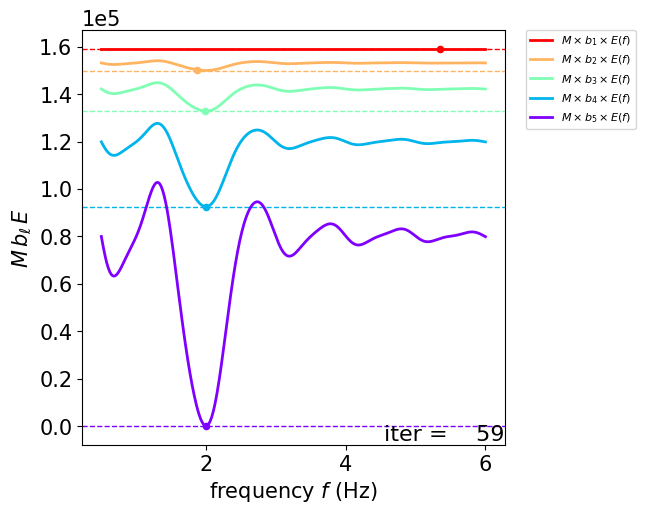

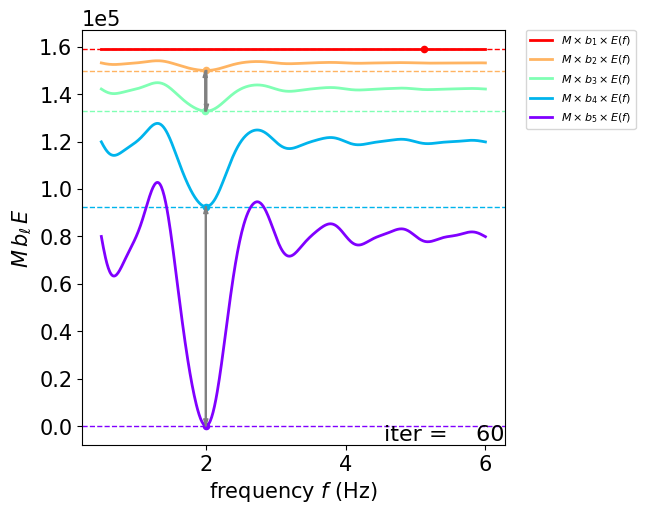

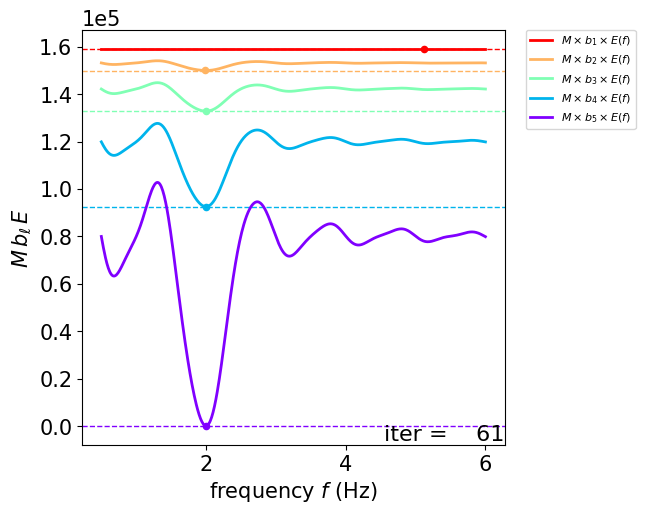

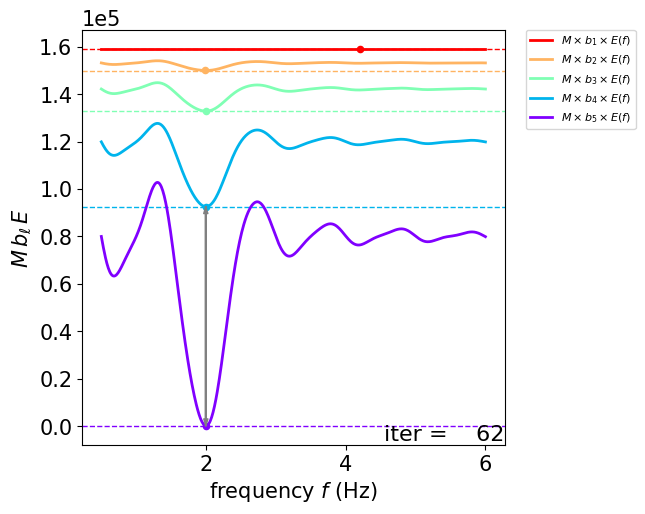

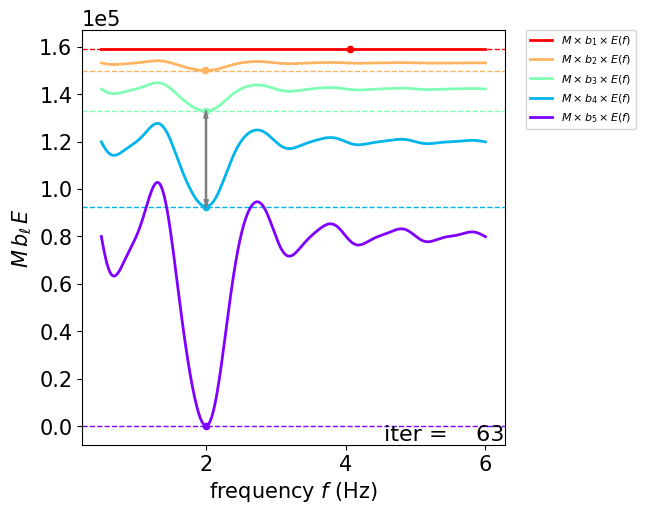

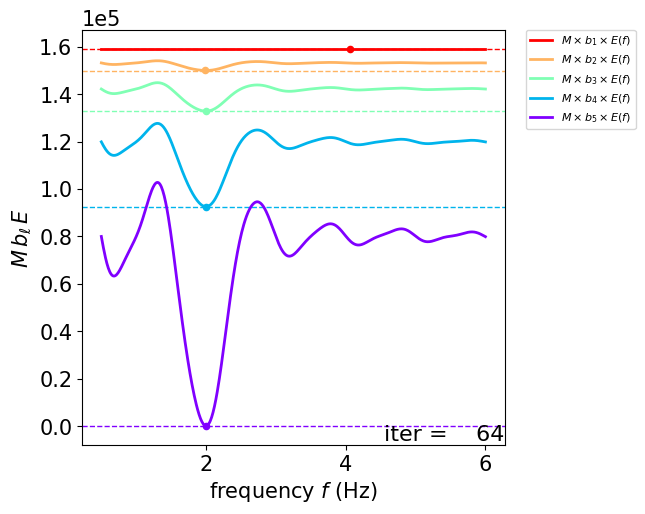

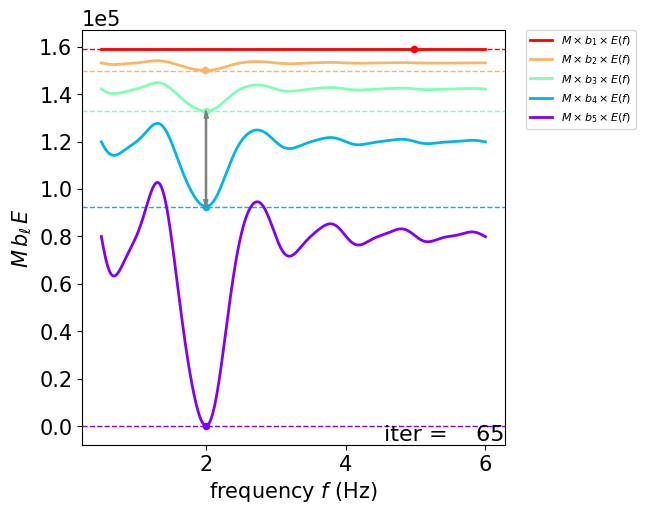

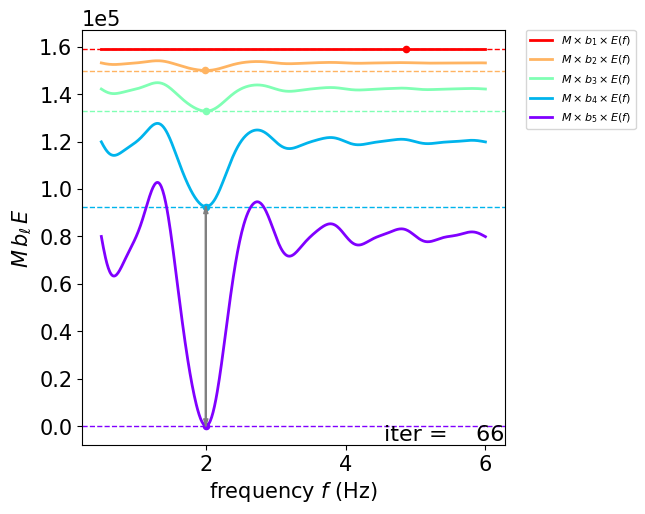

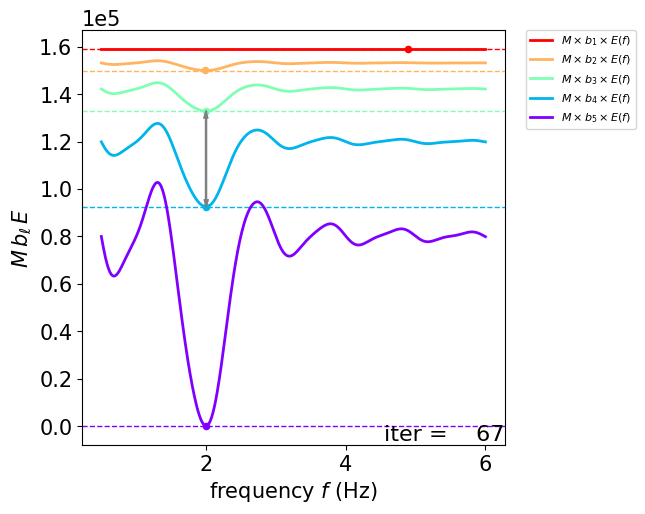

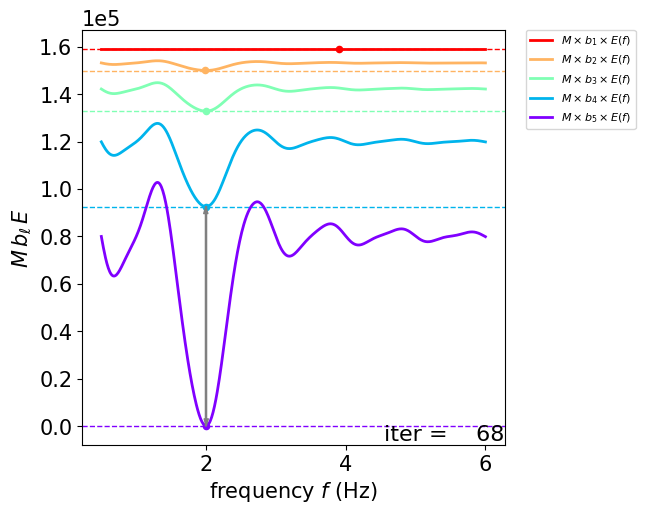

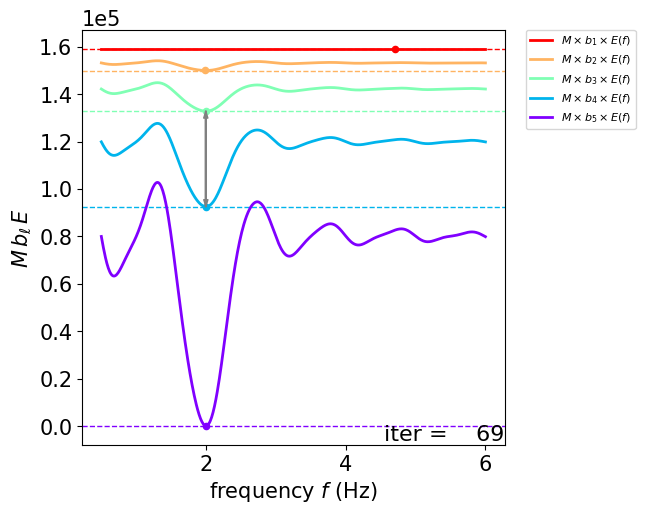

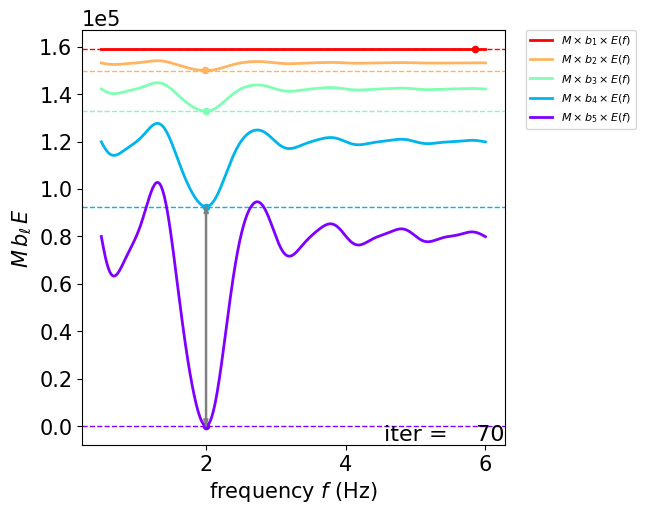

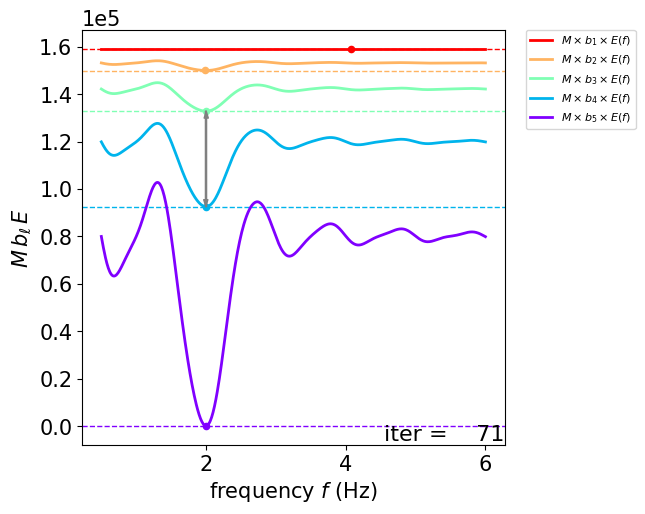

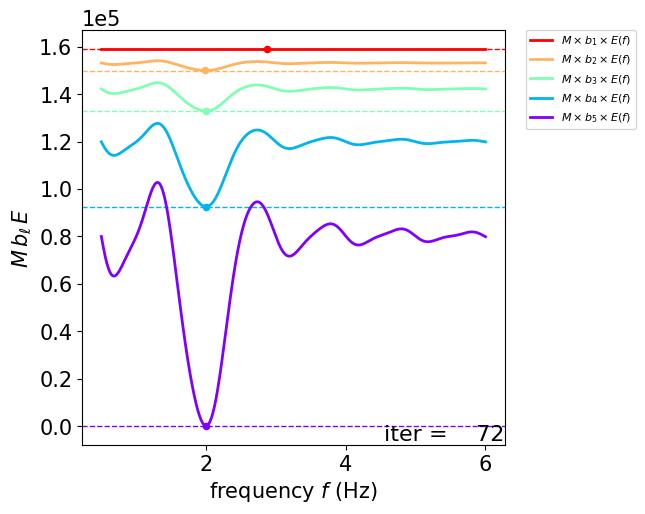

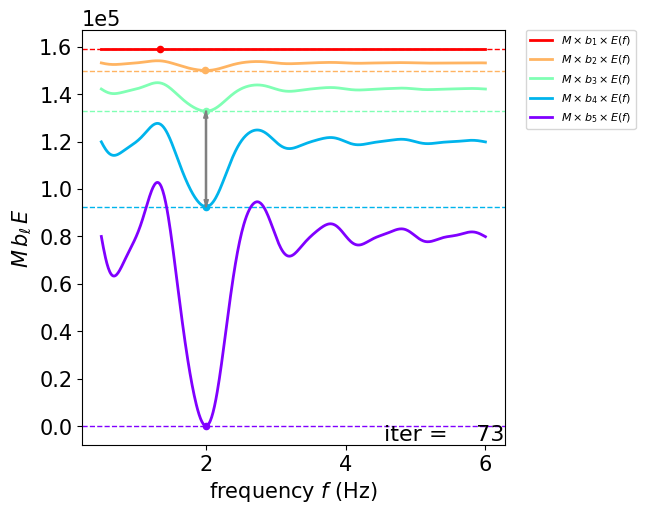

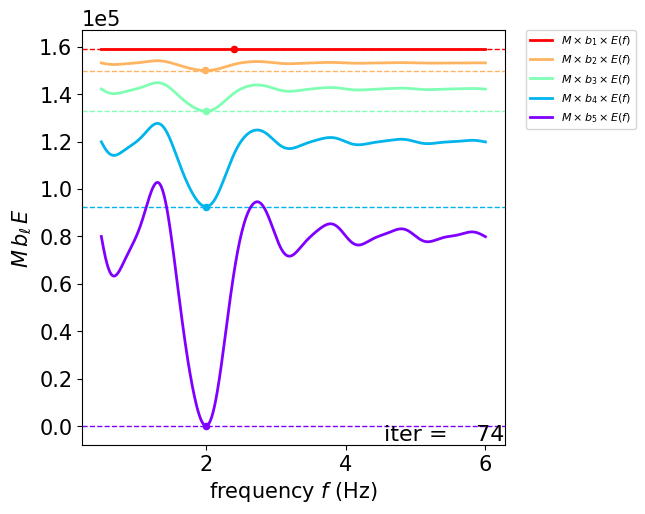

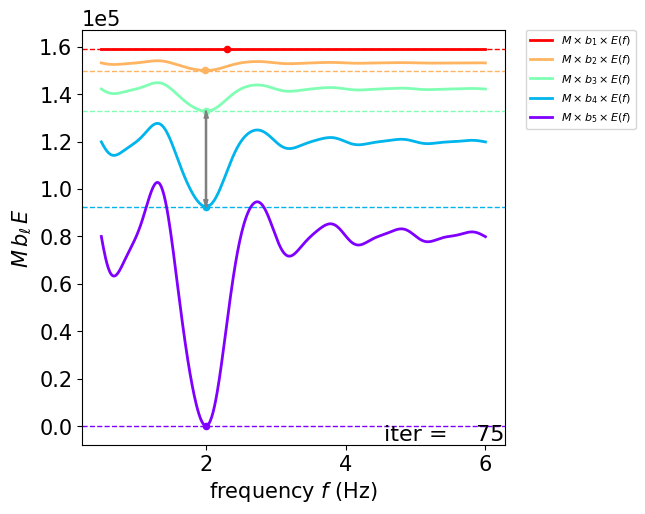

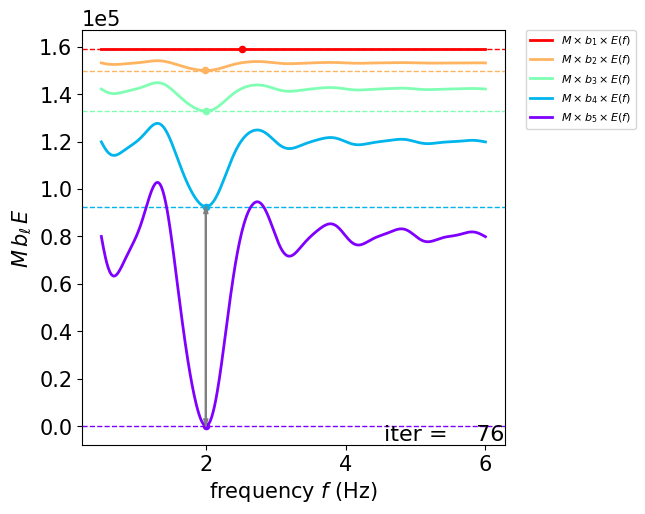

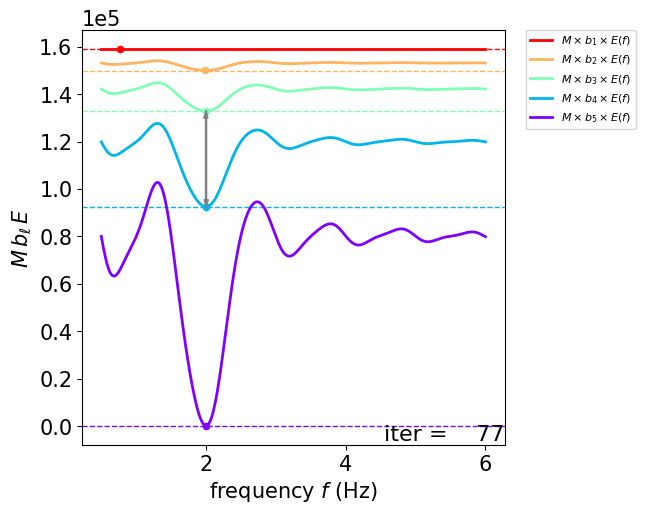

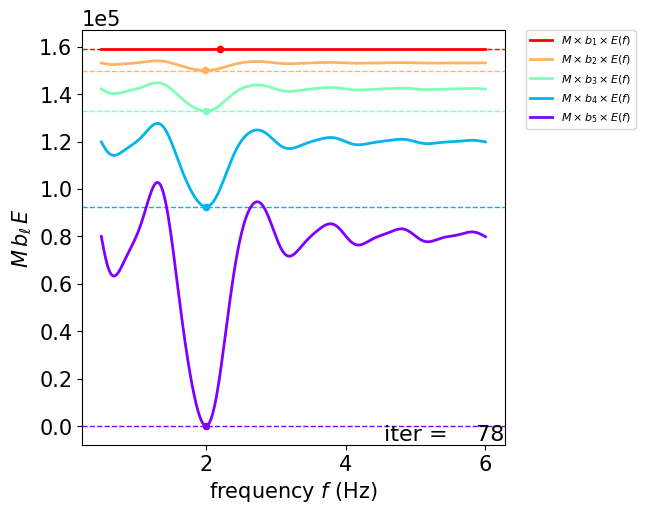

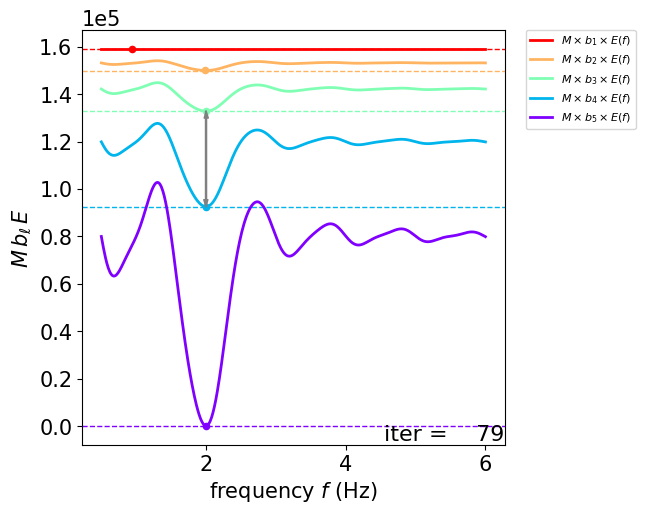

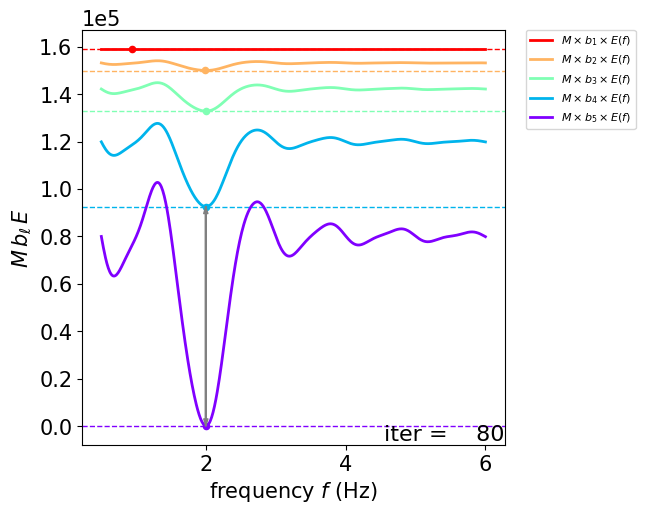

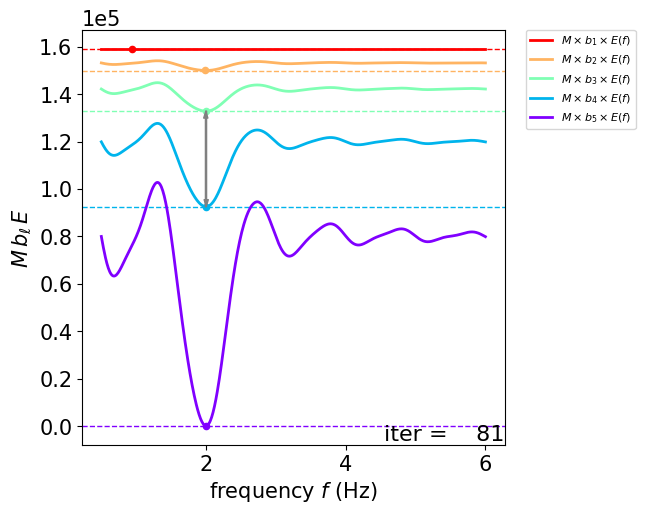

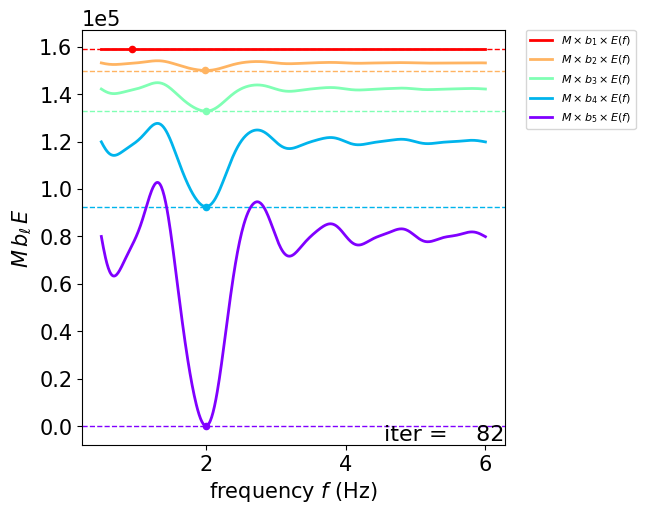

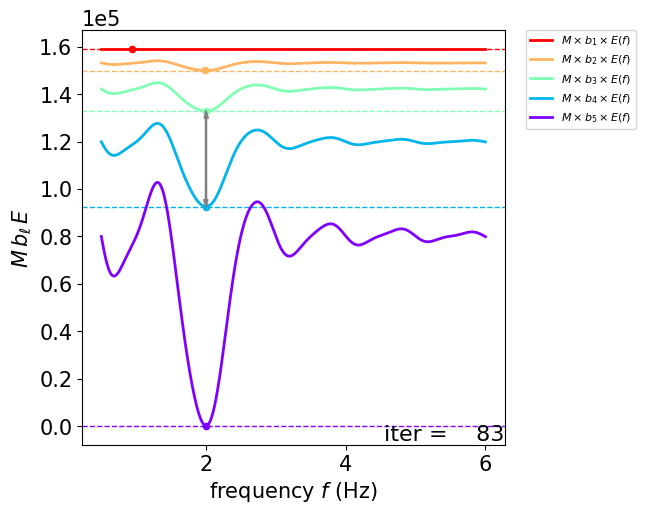

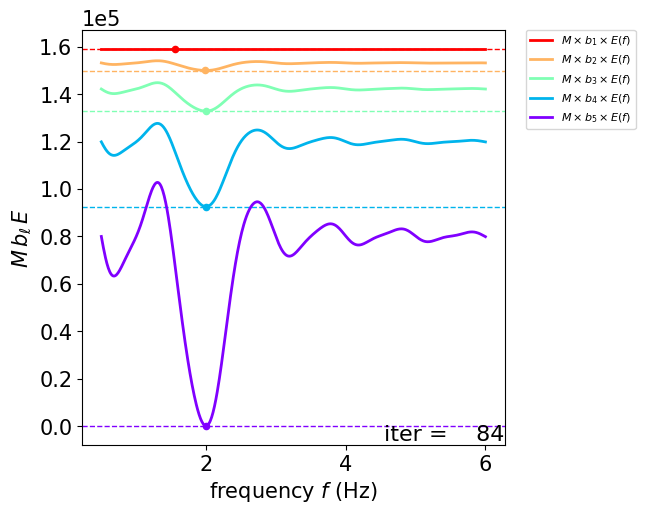

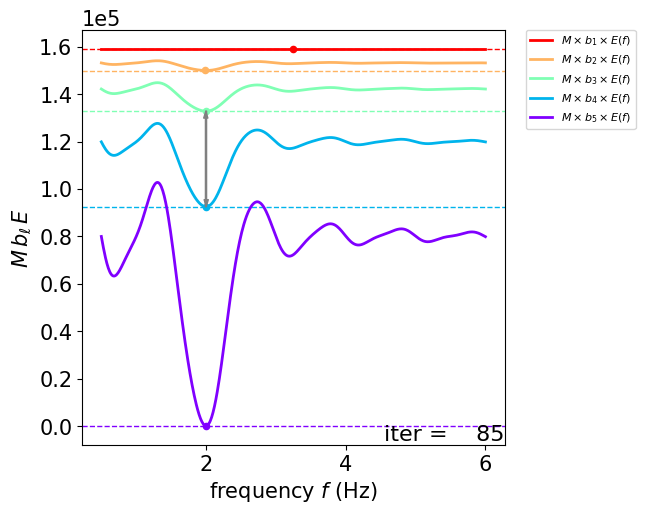

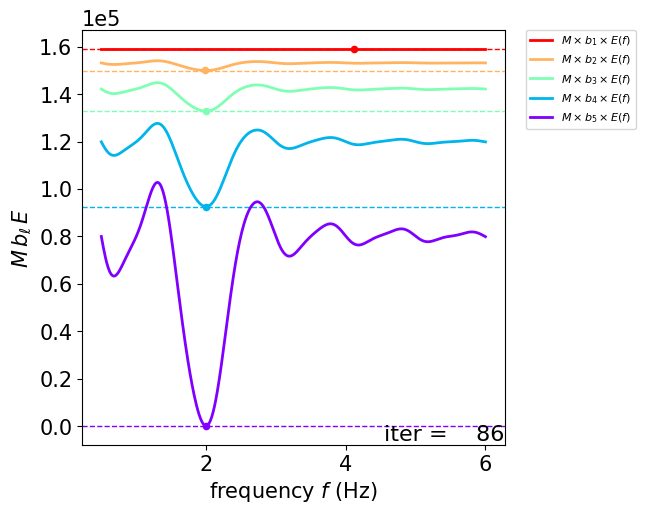

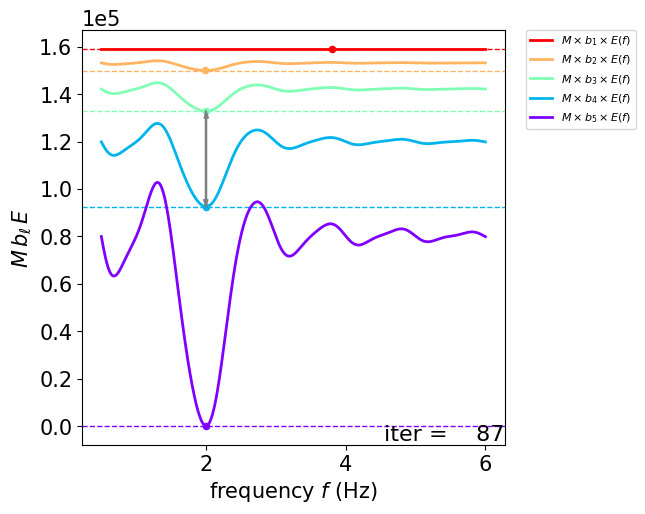

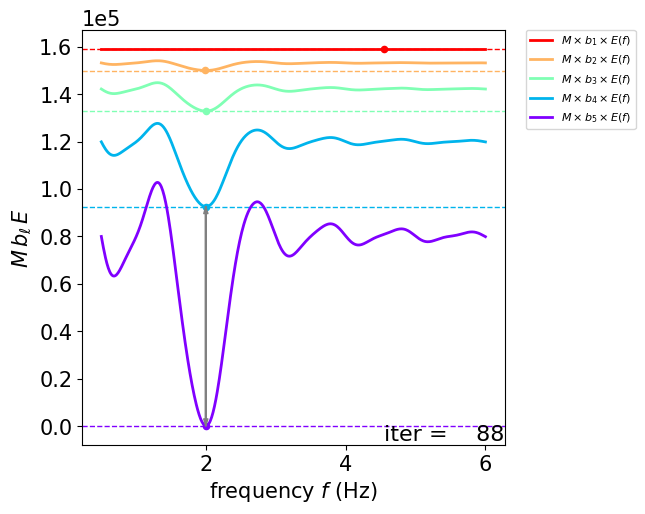

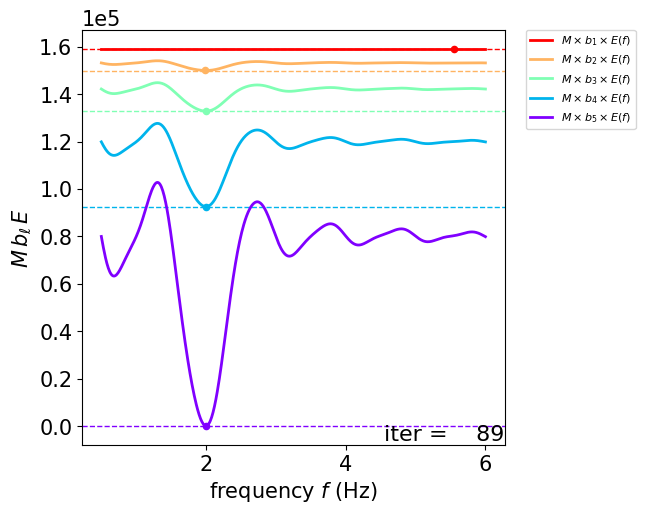

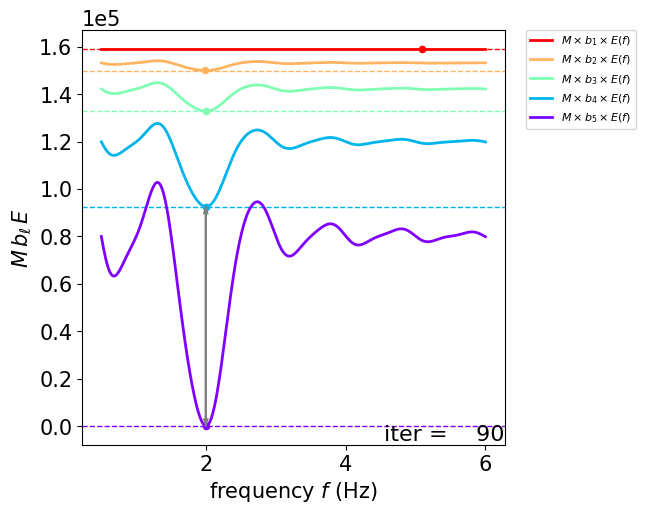

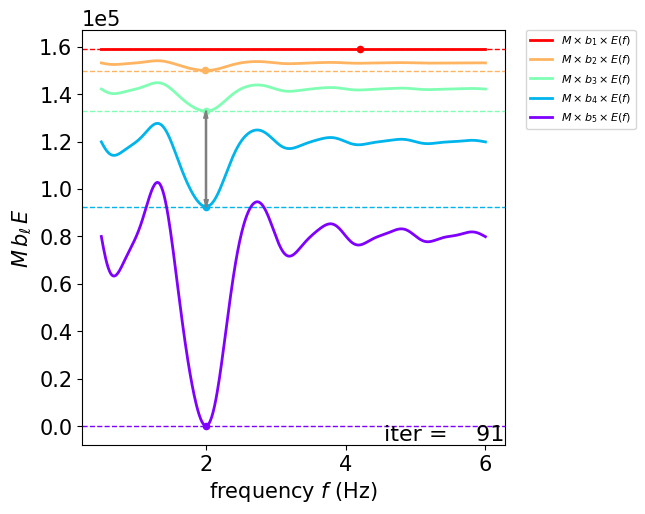

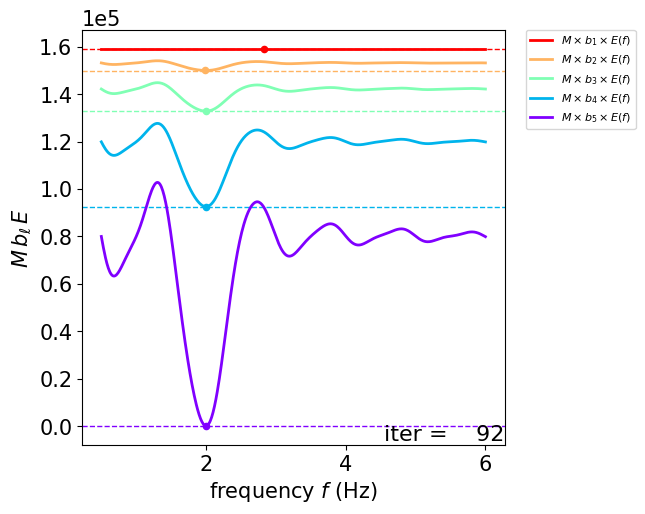

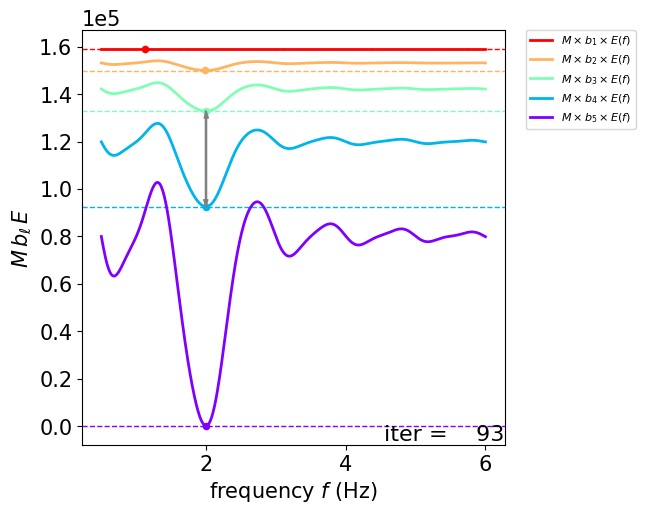

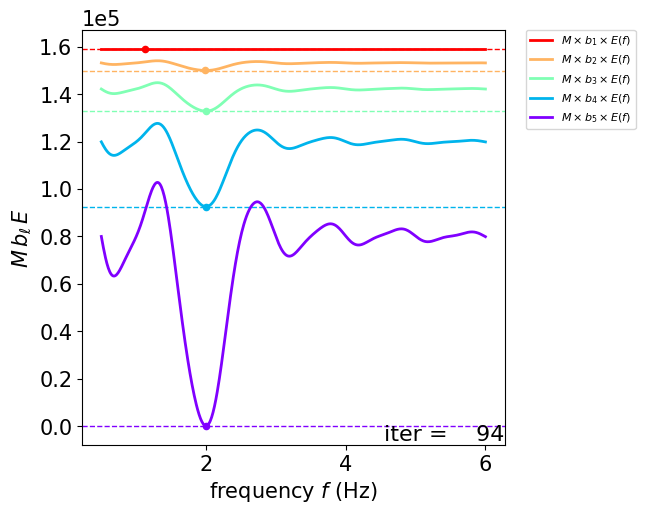

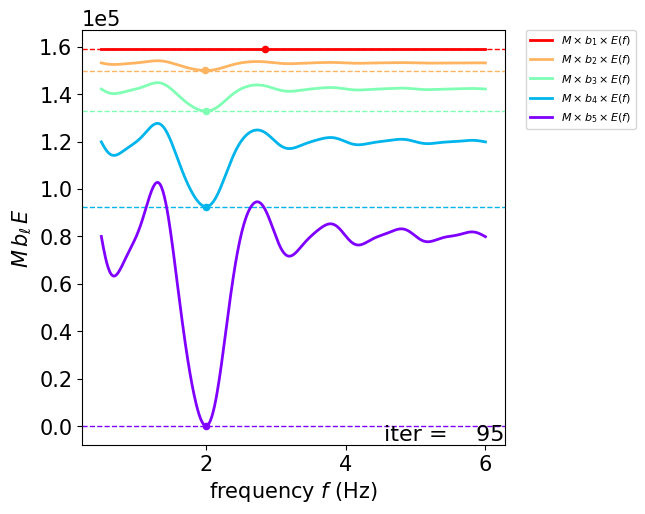

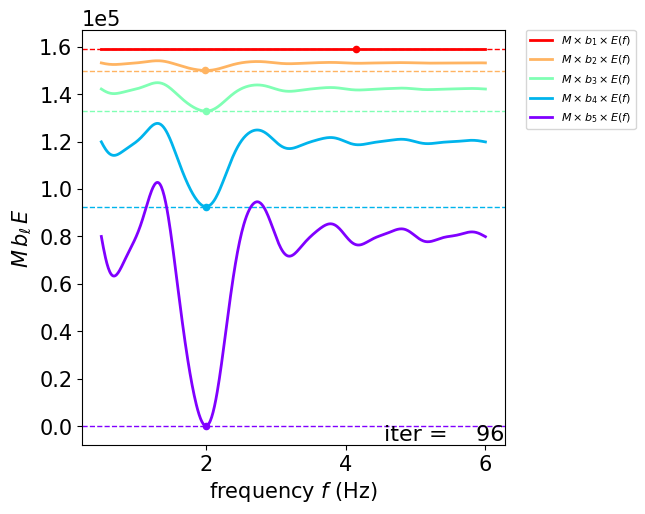

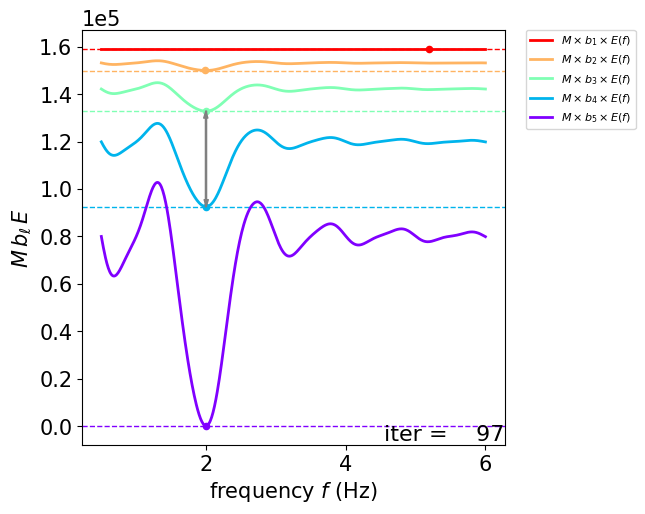

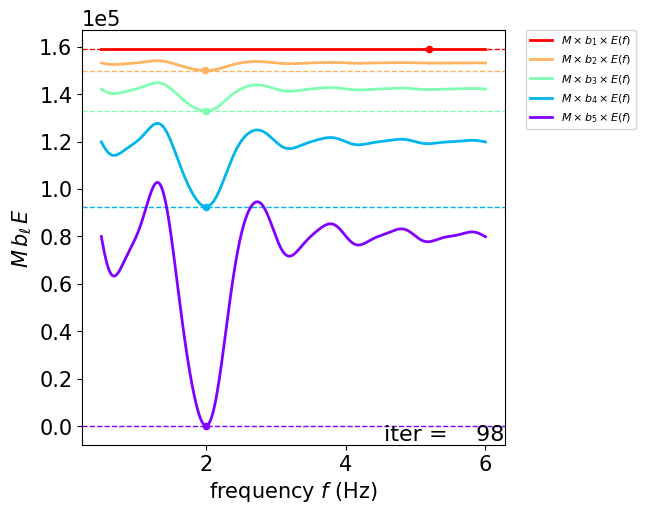

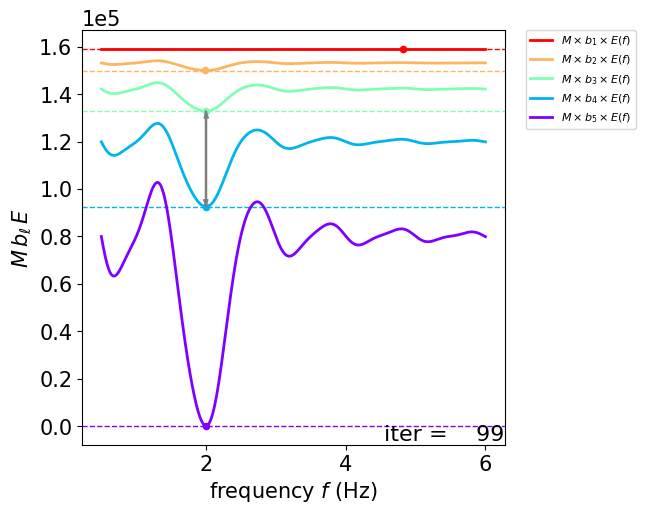

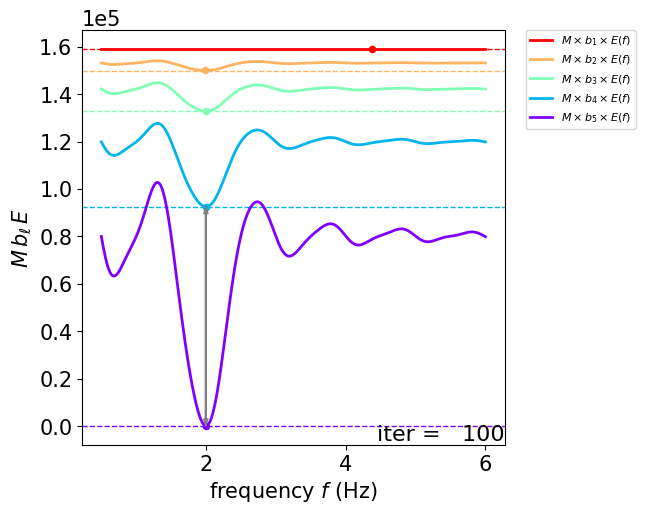

In [19]:
############################################
# デモ用にランダムシード設定
np.random.seed( 7245 )
#
############################################
# 繰り返し回数
iter_max = 100
#
############################################
# 各レプリカで初期値を、事前確率の乱数で生成
f_t = np.random.uniform( f_low, f_high, b_tab_c )
# print( f_t )
#
############################################
# 各レプリカのステップ幅を設定(微調整している)
# f_steps = [ 2.0, 1.0, 0.4, 0.1, 0.02 ]
# f_steps = [ 2.0, 0.016, 0.008, 0.004, 0.002 ]
f_steps = [ 2.0, 0.5, 0.2, 0.1, 0.05 ]
#
############################################
png_list = []
############################################
# 初期値のプロット
y_offsets, plt, fig, ax1, cmap = Grf_RXMC_MbEs( f_data, r'frequency $f$ (Hz)', M, b_tab, E_data,
                                                iter = 0 )
#
for b_idx in range(b_tab_c):
  #
  y_t = M * b_tab[ b_idx ] * E(f_t[ b_idx ]) + y_offsets[ b_idx ]
  #
  ax1.scatter( f_t[ b_idx ], y_t, marker='o', s=30, color=cmap(b_tab_c-1-b_idx) )
  #
############################################
# 初期値のプロットの出力
pngname = FilePath + FileBaseName + '-%05d.png' % 0
fig.savefig( pngname, transparent=True )
#
png_list.append( pngname )
#
############################################
# 繰り返し
for i in range(iter_max):
  #
  y_offsets, plt, fig, ax1, cmap = Grf_RXMC_MbEs( f_data, r'frequency $f$ (Hz)', M, b_tab, E_data,
                                                  iter = (i+1) )
  #
  for b_idx in range(b_tab_c):
    #
    f_t_  = f_t[ b_idx ]
    f_t__ = Metropolis( f_t_, b_tab[ b_idx ], f_steps[ b_idx ] )
    #
    y_t = M * b_tab[ b_idx ] * E(f_t__) + y_offsets[ b_idx ]
    #
    ax1.scatter( f_t__, y_t, marker='o', s=20, color=cmap(b_tab_c-1-b_idx) )
    #
    f_t[ b_idx ] = f_t__
  #
  # 更新
  if( i % 2 == 0 ):
    ex_b_idx_ = 0 # 偶数
  else:
    ex_b_idx_ = 1 # 奇数
  #
  while (ex_b_idx_ + 1) < b_tab_c:
    Exchange( ex_b_idx_, ax1, y_offsets )
    ex_b_idx_ = ex_b_idx_ + 2
  #
  plt.show()
  #
  pngname = FilePath + FileBaseName + '-%05d.png' % (i+1)
  fig.savefig( pngname, transparent=True )
  #
  png_list.append( pngname )
  #
  # pdfname = FilePath + FileBaseName + '-%05d.pdf' % (i+1)
  # fig.savefig( pdfname )
#

出力した png を連結してアニメーション mp4 にする。
* OpenCVが使えない場合で、ffmpeg が使えるならば、
    ```
    ffmpeg -r 8 -i 2RXMC-10demo-%05d.png -vcodec libx264 -pix_fmt yuv420p 2RXMC-10demo-animate.mp4
    ```
* FFmpeg 
    * https://ffmpeg.org/

In [20]:
############################################
mp4name = FilePath + FileBaseName + '-animate.mp4'

In [21]:
############################################
img_array = []
for filename in png_list:
    print( filename )
    img = cv2.imread(filename)
    # print( img.shape )
    height, width, layers = img.shape[:3]
    size = (width, height)
    img_array.append(img)
#
#
# ファイルが存在する場合は削除
if os.path.isfile( mp4name ):
  os.remove( mp4name )
#
out = cv2.VideoWriter(mp4name, cv2.VideoWriter_fourcc(*'mp4v'), 4, size)
#
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

./2RXMC-10demo/2RXMC-10demo-00000.png
./2RXMC-10demo/2RXMC-10demo-00001.png
./2RXMC-10demo/2RXMC-10demo-00002.png
./2RXMC-10demo/2RXMC-10demo-00003.png
./2RXMC-10demo/2RXMC-10demo-00004.png
./2RXMC-10demo/2RXMC-10demo-00005.png
./2RXMC-10demo/2RXMC-10demo-00006.png
./2RXMC-10demo/2RXMC-10demo-00007.png
./2RXMC-10demo/2RXMC-10demo-00008.png
./2RXMC-10demo/2RXMC-10demo-00009.png
./2RXMC-10demo/2RXMC-10demo-00010.png
./2RXMC-10demo/2RXMC-10demo-00011.png
./2RXMC-10demo/2RXMC-10demo-00012.png
./2RXMC-10demo/2RXMC-10demo-00013.png
./2RXMC-10demo/2RXMC-10demo-00014.png
./2RXMC-10demo/2RXMC-10demo-00015.png
./2RXMC-10demo/2RXMC-10demo-00016.png
./2RXMC-10demo/2RXMC-10demo-00017.png
./2RXMC-10demo/2RXMC-10demo-00018.png
./2RXMC-10demo/2RXMC-10demo-00019.png
./2RXMC-10demo/2RXMC-10demo-00020.png
./2RXMC-10demo/2RXMC-10demo-00021.png
./2RXMC-10demo/2RXMC-10demo-00022.png
./2RXMC-10demo/2RXMC-10demo-00023.png
./2RXMC-10demo/2RXMC-10demo-00024.png
./2RXMC-10demo/2RXMC-10demo-00025.png
./2RXMC-10de

mp4 が生成できたら、png を削除しておく。

In [22]:
############################################
if os.path.isfile( mp4name ):
  for filename in png_list:
    os.remove( filename )